In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from typing import List, Optional
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from environment import ManipulatorEnv, State


def animate_plan(env: ManipulatorEnv, plan: List[State], video_output_file: Optional[str] = "solve_4R.avi"):
    """
    Visualizes the plan with pyplot and, optionally, saves it to the video file.

    :param env: Manipulator environment
    :param plan: Plan - sequence of states
    :param video_output_file: If not None, saves animation to this file. Suggested extension is .avi.
    """
    video_writer = None
    fig = plt.figure()
    ax = plt.gca()
    ax.set_xlim([-4, 4])
    ax.set_ylim([-2.5, 2.5])
    for i, state in enumerate(plan):
        env.state = state
        env.render(plt_show=False)

        canvas = FigureCanvas(fig)
        canvas.draw()
        mat = np.array(canvas.renderer._renderer)
        mat = cv2.cvtColor(mat, cv2.COLOR_RGB2BGR)
        if video_writer is not None:
            video_writer.write(mat)
        elif video_output_file is not None:
            video_writer = cv2.VideoWriter(video_output_file, cv2.VideoWriter_fourcc(*'XVID'), 10,
                                           (mat.shape[1], mat.shape[0]))
            video_writer.write(mat)

        if i != len(plan) - 1:
            plt.pause(0.05)
            plt.clf()
        else:
            if video_writer is not None:
                video_writer.release()
            plt.show()


In [2]:
from typing import Union
import numpy as np


def angle_difference(angle1: Union[float, np.ndarray],
                     angle2: Union[float, np.ndarray],
                     directional=False) -> Union[float, np.ndarray]:
    """
    :param angle1: first angle in degrees
    :param angle2: second angle in degrees
    :param return: signed diff between angles (from 0 to 180)
    """
    if type(angle1) is np.ndarray:
        assert type(angle1) == type(angle2)
        assert angle1.shape == angle2.shape
        return np.array([angle_difference(a1, a2) for (a1, a2) in zip(angle1, angle2)])
    delta_angle = angle1 - angle2
    delta_angle = (delta_angle + 180) % 360 - 180
    return delta_angle


def angle_linspace(start_angle: Union[float, np.ndarray],
                   end_angle: Union[float, np.ndarray],
                   n: int):
    """
    :param start_angle: start angle (or whole configuration) in degrees
    :param end_angle: end angle (or whole configuration) in degrees
    :param n: number of steps
    """
    if type(start_angle) is np.ndarray:
        assert type(start_angle) == type(end_angle)
        assert start_angle.shape == end_angle.shape
        return np.array([angle_linspace(a1, a2, n) for (a1, a2) in zip(start_angle, end_angle)]).T

    step = angle_difference(end_angle, start_angle) / n
    result = [start_angle]
    for _ in range(n):
        new_item = result[-1] + step
        if np.abs(new_item) > 180.0:
            if new_item > 0.0:
                new_item = new_item - 360.0
            else:
                new_item = new_item + 360.0
        result.append(new_item)
    return np.array(result)


In [3]:
import numpy as np
import matplotlib.pyplot as plt


class State:

    def __init__(self, angles: np.ndarray):
        """
        Represents the state of the 4-link manipulator.

        :param angles: 4 angles for each link of the manipulator in degrees. Shape: (4,).
        """
        assert angles.shape == (4,)
        assert (np.abs(angles) >= 0.0).all() and (np.abs(angles) <= 180.0).all()
        self._angles = angles.copy()
        self._joints = State._calculate_joint_positions(angles)

    @property
    def angles(self) -> np.ndarray:
        """
        :return: 4 angles for each link of the manipulator in degrees
        """
        return self._angles

    @property
    def joints(self) -> np.ndarray:
        """
        :return: Positions of the 5 joints of the manipulator. Shape: (5, 2).
        """
        return self._joints

    @staticmethod
    def _calculate_joint_positions(angles: np.ndarray) -> np.ndarray:
        seg = np.zeros((5, 2))
        a1, a2, a3, a4 = np.deg2rad(angles)
        T1 = State._se2(np.array([0, 0, a1]))  # this is the first joint, a simple rotation
        T2 = State._se2(
            np.array([1, 0, a2]))  # the second joint, it is a bar of d =1, plus a rotation for the second joint
        T3 = State._se2(np.array([1, 0, a3]))
        T4 = State._se2(np.array([1, 0, a4]))
        T5 = State._se2(
            np.array([1, 0, 0]))  # this is simply to express the lenght of the second bar, no rotation required
        p = T1 @ T2 @ np.array([0, 0, 1])
        seg[1, :] = p[:2]
        p = T1 @ T2 @ T3 @ np.array([0, 0, 1])
        seg[2, :] = p[:2]
        p = T1 @ T2 @ T3 @ T4 @ np.array([0, 0, 1])
        seg[3, :] = p[:2]
        p = T1 @ T2 @ T3 @ T4 @ T5 @ np.array([0, 0, 1])
        seg[4, :] = p[:2]
        return seg

    @staticmethod
    def _se2(q):
        x, y, t = q
        T = np.array([
            [np.cos(t), -np.sin(t), x],
            [np.sin(t), np.cos(t), y],
            [0, 0, 1]])
        return T


class ManipulatorEnv:

    OBSTACLES_DIM = 3  # x, y, radius (assume all obstacles are circles)
    N_LINKS = 4

    def __init__(self,
                 obstacles: np.ndarray,
                 initial_state: State,
                 collision_threshold: float = 0.1):
        assert len(obstacles.shape) == 2 and obstacles.shape[1] == ManipulatorEnv.OBSTACLES_DIM
        self._obstacles = obstacles.copy()
        self._state = initial_state
        self._collision_threshold = collision_threshold

    @property
    def state(self) -> State:
        return self._state

    @state.setter
    def state(self, new_state: State) -> None:
        self._state = new_state

    def check_collision(self, state_to_check: State) -> bool:
        """
        Checks state (configuration) for the collisions.
        :return True if collision, False if no collisions
        """
        for obs in self._obstacles:
            for i in range(ManipulatorEnv.N_LINKS):
                segment = state_to_check.joints[[i, i+1], :]
                r = obs[2] + self._collision_threshold
                p0 = obs[:2]
                p1 = segment[0]
                p2 = segment[1]

                # Check if p1 or p2 in circle
                if np.linalg.norm(p0 - p1) <= r or np.linalg.norm(p0 - p2) <= r:
                    return True

                # Find projection
                t = np.sum((p0 - p1) * (p2 - p1)) / (np.linalg.norm(p2 - p1) ** 2)
                # Check if the projection is on the line
                # (in other words, if line is fully in the circle)
                if t < 0.0 or t > 1.0:
                    continue
                p4 = p1 + t * (p2 - p1)

                if np.linalg.norm(p0 - p4) <= r:
                    return True

        return False

    def render(self, plt_show=True) -> None:
        """
        Displays current configuration.
        :param plt_show: whether to call plt.show() or not
        """
        self._plot_segment(self._state.joints[[0, 1], :], np.array([1, 0, 0]),
                           is_start_link=True)
        self._plot_segment(self._state.joints[[1, 2], :], np.array([0, 1, 0]))
        self._plot_segment(self._state.joints[[2, 3], :], np.array([0, 0, 1]))
        self._plot_segment(self._state.joints[[3, 4], :], np.array([1, 0, 1]),
                           is_end_link=True)
        for obs in self._obstacles:
            plt.gca().add_patch(
                plt.Circle((obs[0], obs[1]), obs[2], fill=True))
        plt.axis('equal')
        if plt_show:
            plt.show()

    @staticmethod
    def _plot_segment(s, color_, is_start_link=False, is_end_link=False):
        plt.plot(s[:, 0], s[:, 1], linewidth=2, color=color_)
        if is_end_link:
            plt.plot(s[1, 0], s[1, 1], marker='>', color=color_)
        else:
            plt.plot(s[1, 0], s[1, 1], marker='o', color=color_)
        if is_start_link:
            plt.plot(s[0, 0], s[0, 1], marker='X', color=color_)
        else:
            plt.plot(s[0, 0], s[0, 1], marker='o', color=color_)


In [4]:
import numpy as np
import pickle
from environment import State, ManipulatorEnv
from rrt import RRTPlanner
from video_util import animate_plan


# You are free to change any interfaces for your needs.


def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)

    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=start_state,
                         collision_threshold=data["collision_threshold"])
    
    #planner = RRTPlanner(env)

    #plan = planner.plan(start_state, goal_state)
    #print("RRT planner has finished successfully")

    #animate_plan(env, plan)

# Task 1: Visualization

# Subtask A

Visualize the manipulator in the start state and target state. Comment on your thoughts about
comparison the discretized orientation space from PS1 vs continuous orientation space in current problem
set.

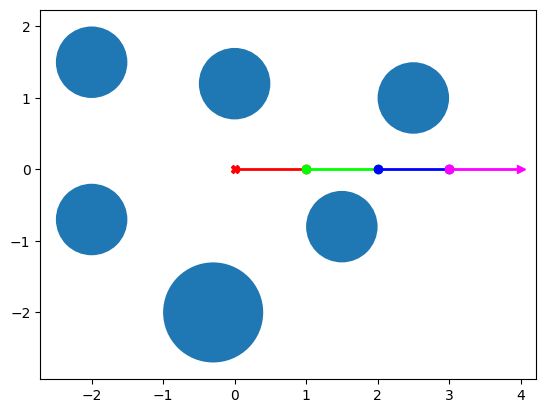

In [5]:
def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)

    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=start_state,
                         collision_threshold=data["collision_threshold"])

    env.render()
if __name__ == '__main__':
    main()

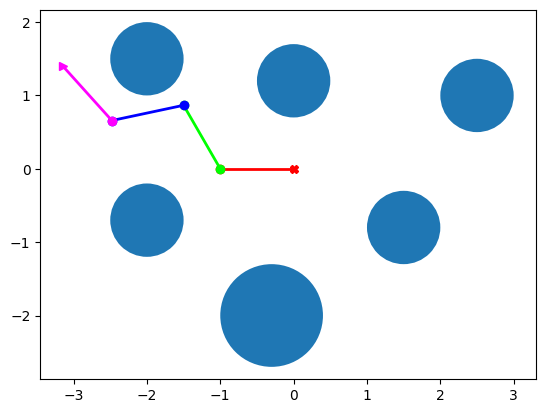

In [6]:
def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)

    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=goal_state,
                         collision_threshold=data["collision_threshold"])

    env.render()
if __name__ == '__main__':
    main()

Continuous orientation space in the current Problem set allows to represent such a complex rigid object with several joints, while in the discretized orientation space it would be impossible.

## Subtask B

Visualize the manipulator in 4 random orientations that include both colliding and non-colliding
configurations. Check what does the ManipulatorEnv.check_collision function returns for those
configurations. Comment on your observations.

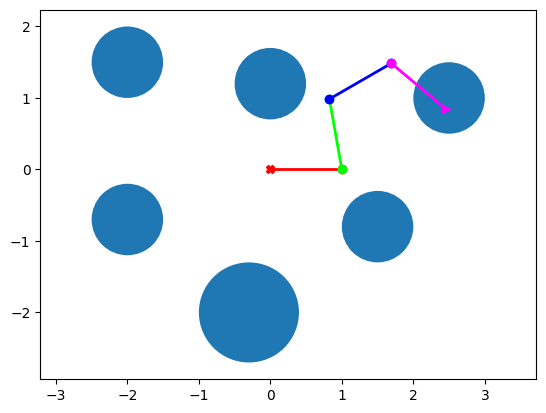

Is here a collision? The answer is: True


In [7]:
def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
        
    current_state = State(np.array([0.0, 100.0, -70.0, -70.0]))
    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=current_state,
                         collision_threshold=data["collision_threshold"])


    env.render()
    print("Is here a collision? The answer is:", env.check_collision(current_state))
if __name__ == '__main__':
    main()

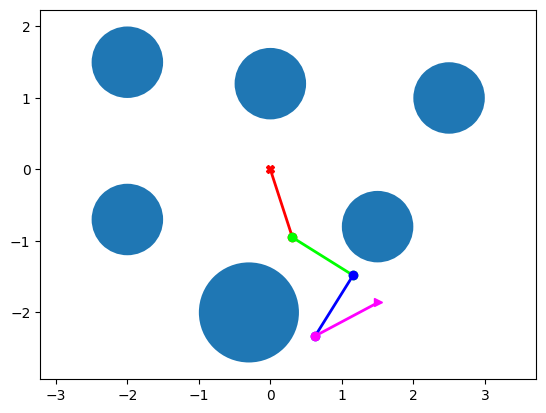

Is here a collision? The answer is: False


In [8]:
def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
        
    current_state = State(np.array([-72.0, 40.0, -90.0, 150.0]))
    
    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=current_state,
                         collision_threshold=data["collision_threshold"])


    env.render()
    print("Is here a collision? The answer is:", env.check_collision(current_state))
if __name__ == '__main__':
    main()

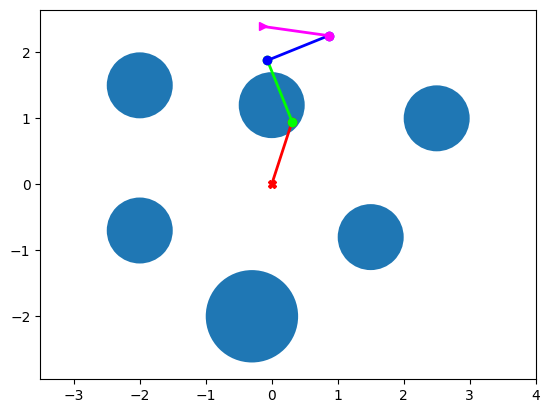

Is here a collision? The answer is: True


In [9]:
def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
        
    current_state = State(np.array([72.0, 40.0, -90.0, 150.0]))
    
    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=current_state,
                         collision_threshold=data["collision_threshold"])


    env.render()
    print("Is here a collision? The answer is:", env.check_collision(current_state))
if __name__ == '__main__':
    main()

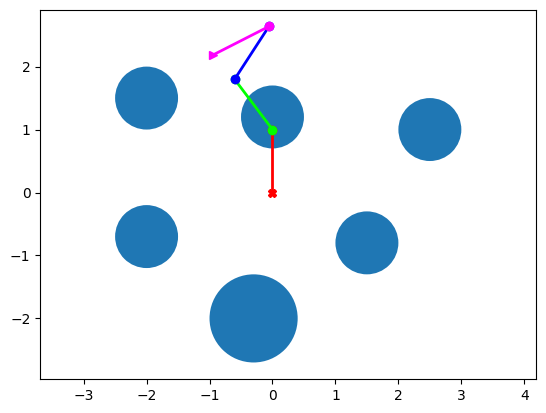

Is here a collision? The answer is: True


In [10]:
def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
        
    current_state = State(np.array([90.0, 37.0, -70.0, 150.0]))
    
    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=current_state,
                         collision_threshold=data["collision_threshold"])

    env.render()
    print("Is here a collision? The answer is:", env.check_collision(current_state))
    
if __name__ == '__main__':
    main()

Obviously, the collision check returns 'True', if there is a collision between an obstacle and one of the rods of the manipulator. On the last plot visually there is no collision (there are several pixels between the manipulator and the circle), but it considers as it is, because there is a circle of a particular radius, that is assumed as an obstacle. This is a forced inaccuracy for solving the task.

# Task 2

## Subtask A

You need to implement the RRT algorithm for agent in continuous domain. The starting configuration of the agent is $(0, 0, 0, 0)$ and the goal configuration is $(-180.0, -60.0, 72.0, -60.0)$.\
For searching nearest pose use $L_1$ distance between two configuration vectors:
$$distance = \|q_2 - q_1 \|_1$$
You may want to use function angle_difference and angle_linspace from **angle_utils.py**. As a
maximum allowed rotation for each joint we suggest you to use 10 degrees.


Save the result of calculated plan in **solve_4R.mp4** (or other video extension) using provided function. If
you want to add more smoothness to the video, you can add additional intermediate configurations, but it’s
optional

You may want to use the function **ManipulatorEnv.check_collision**, in order to check if the the manipulator is in collision at any point towards the new configuration.

*Hint*: you may want to use the collision check function over a small sequence of configurations, connecting
your current one with the new configuration candiate $q_{new}$.

{'start_state': [0.0, 0.0, 0.0, 0.0], 'goal_state': [-180.0, -60.0, 72.0, -60.0], 'obstacles': [[2.5, 1.0, 0.5], [1.5, -0.8, 0.5], [-2, -0.7, 0.5], [-2, 1.5, 0.5], [0.0, 1.2, 0.5], [-0.3, -2.0, 0.7]], 'collision_threshold': 0.1}
There have been visited 827 states
The plan length: 53


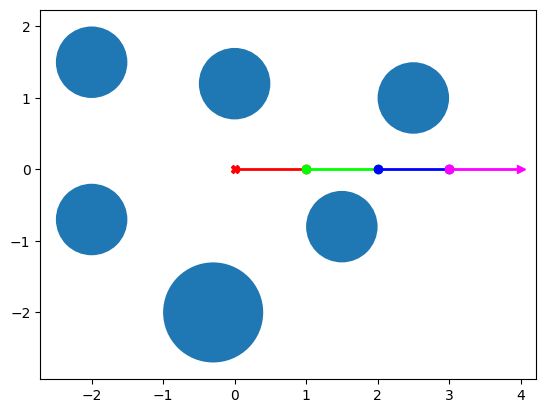

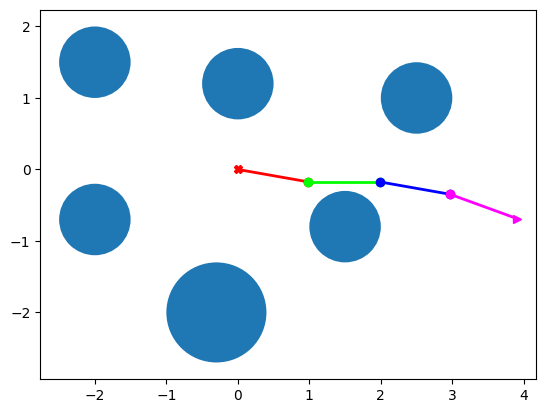

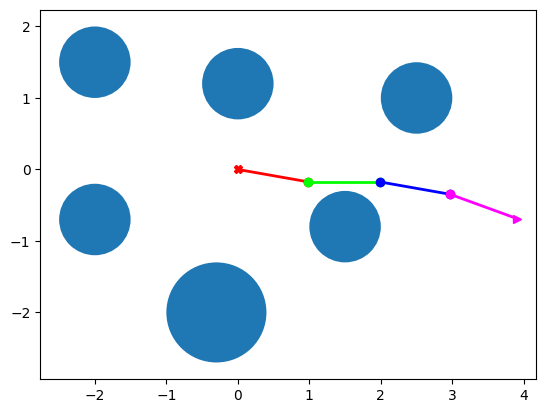

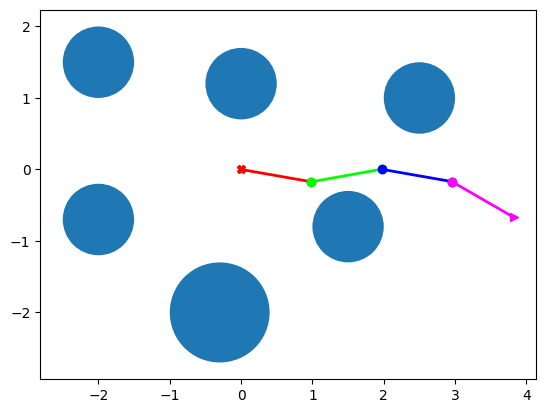

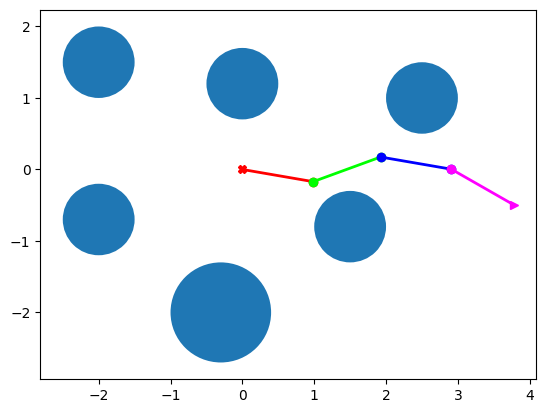

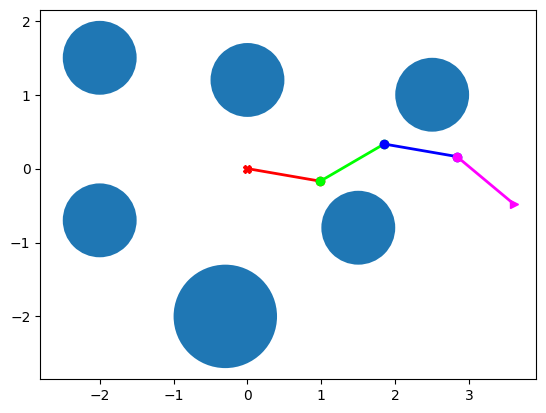

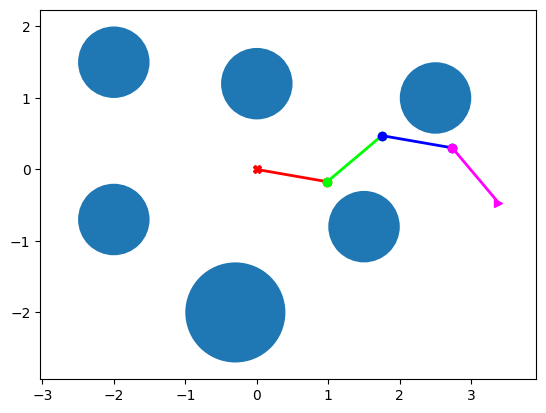

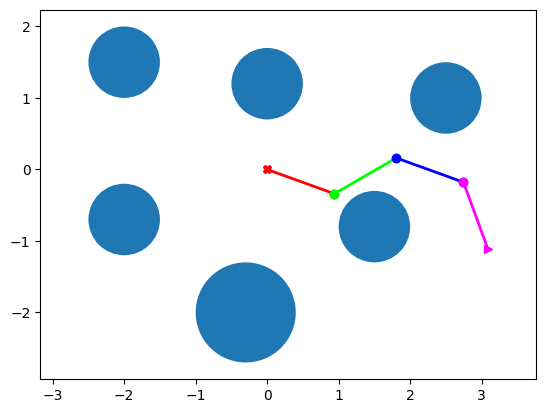

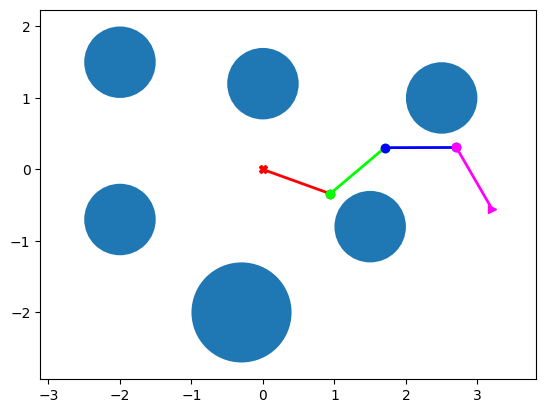

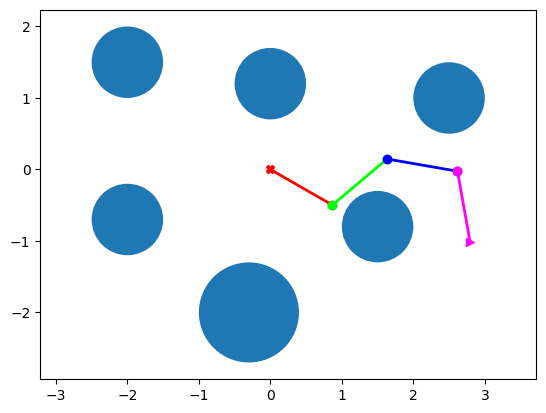

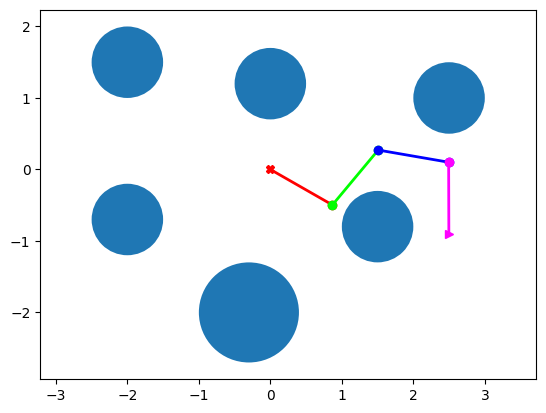

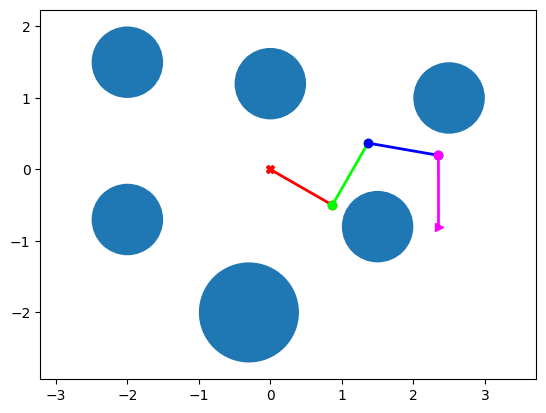

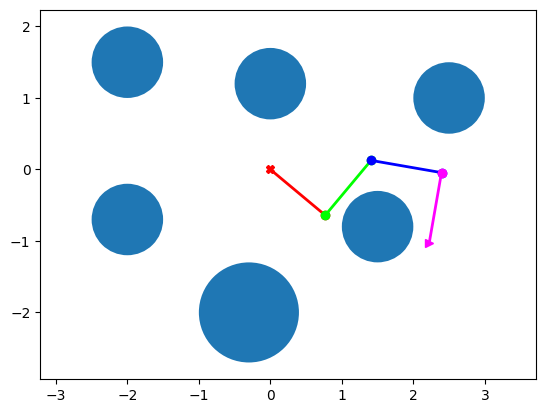

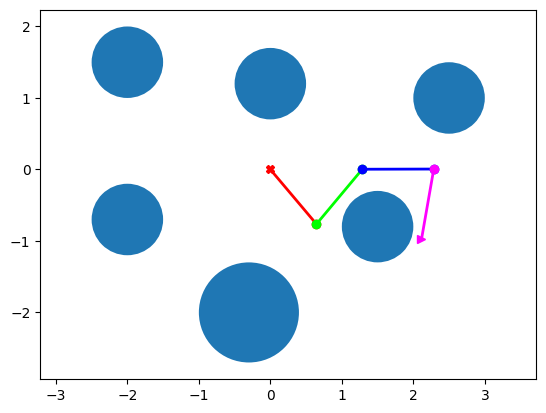

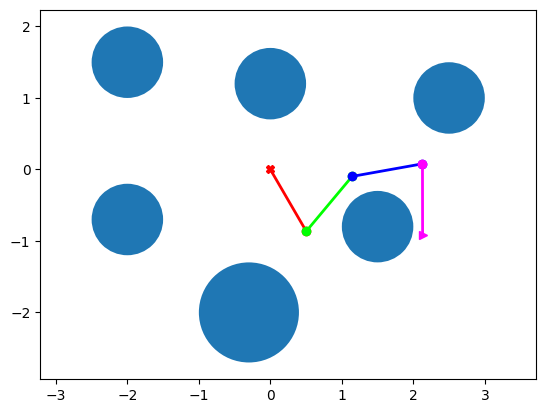

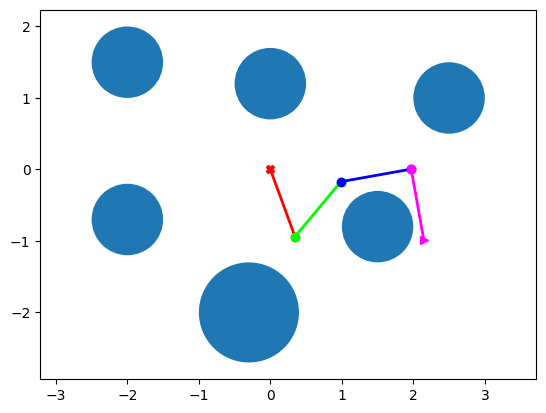

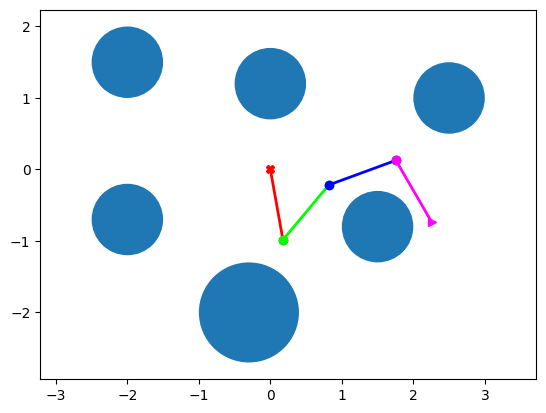

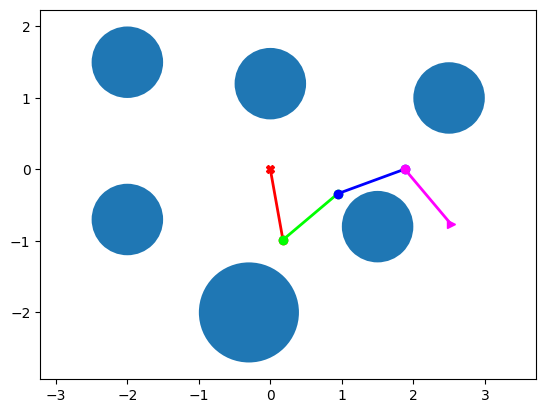

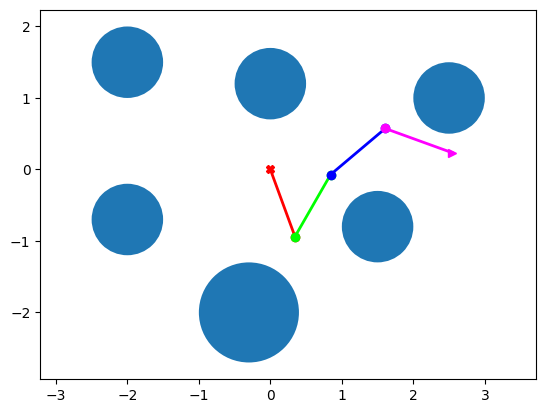

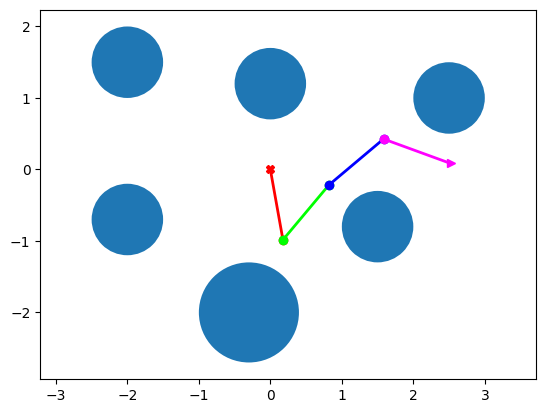

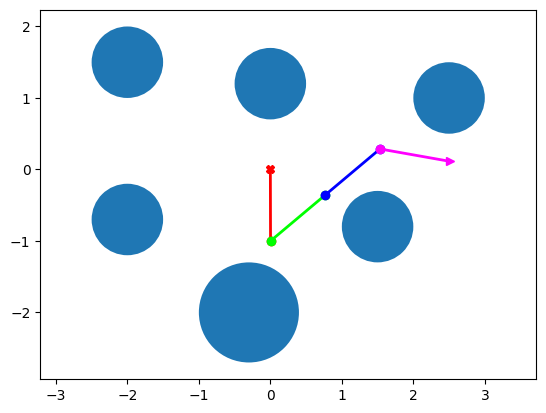

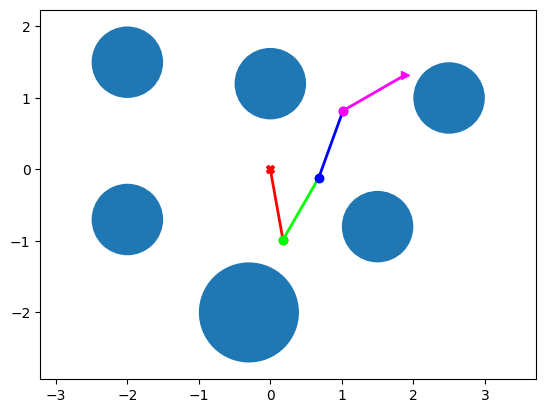

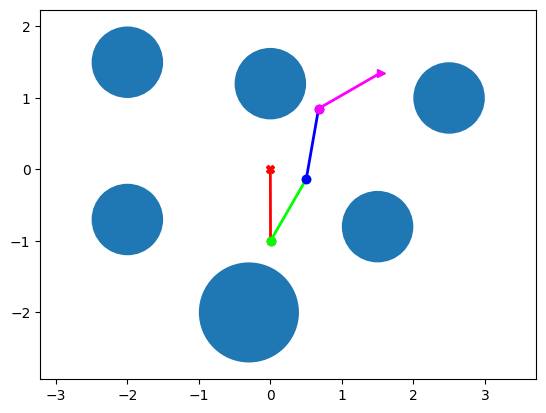

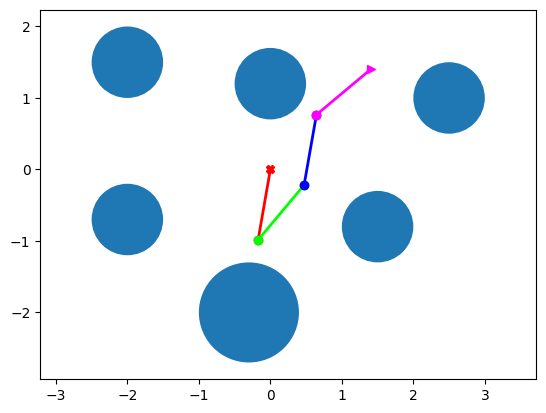

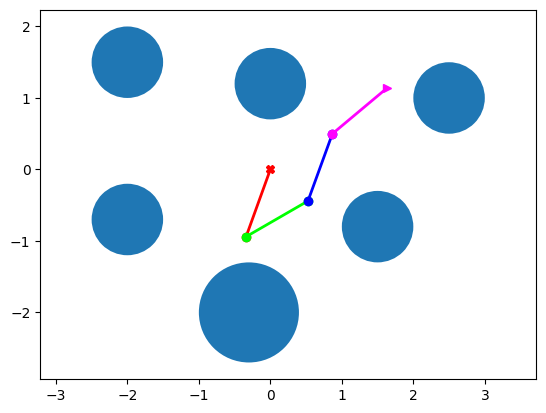

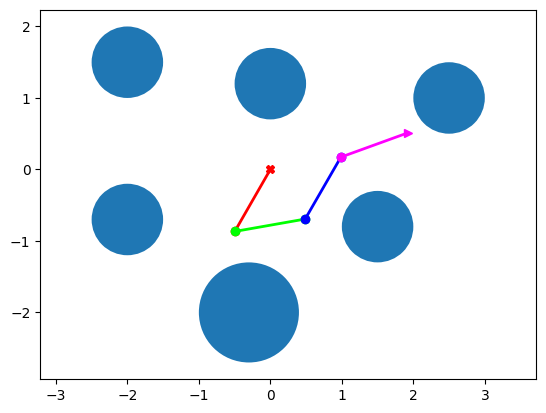

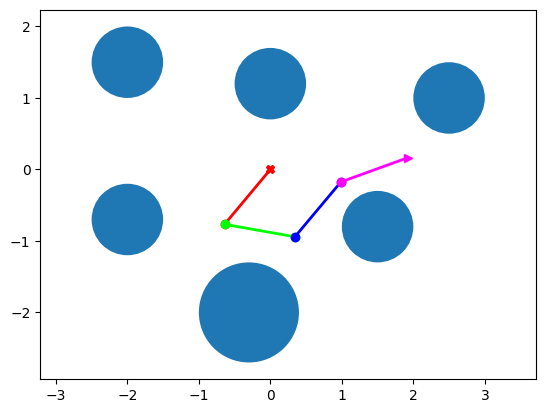

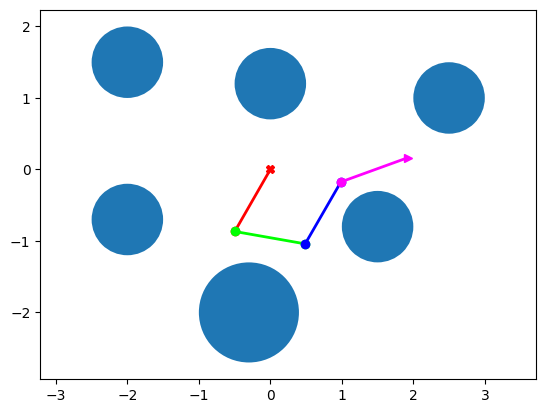

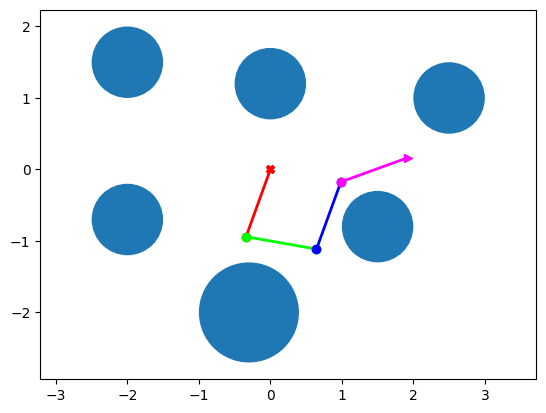

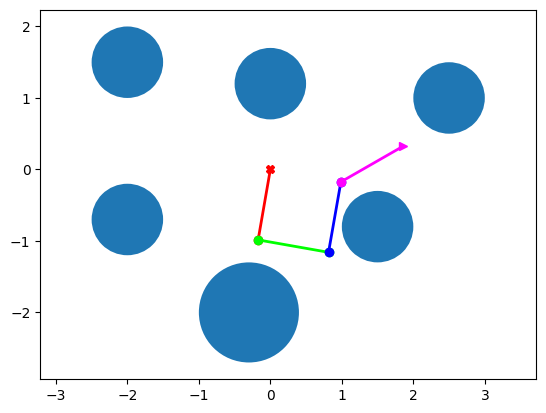

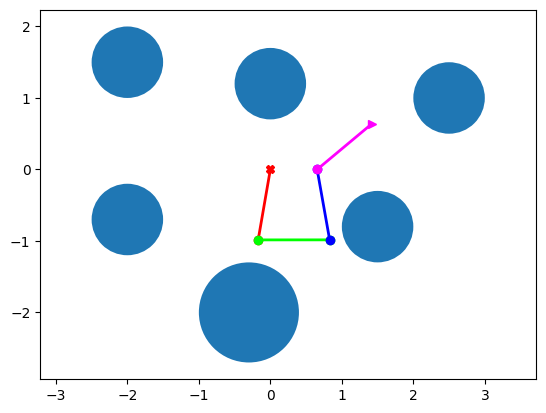

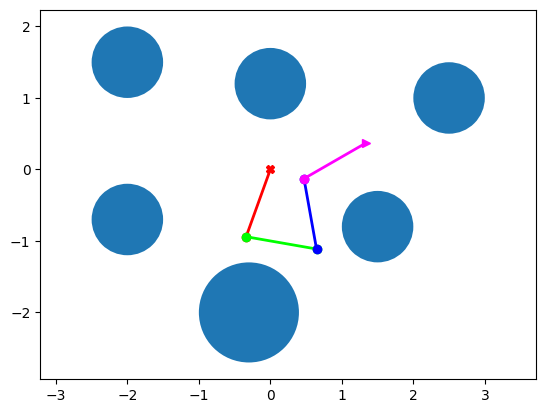

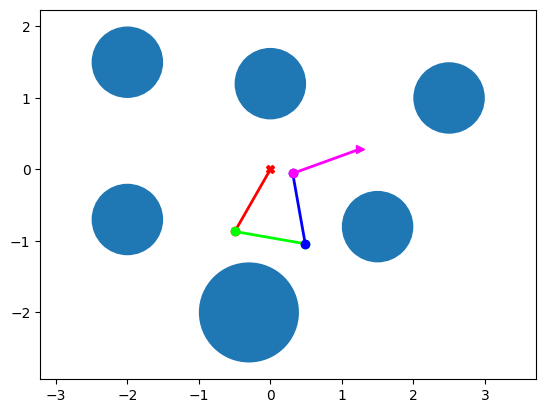

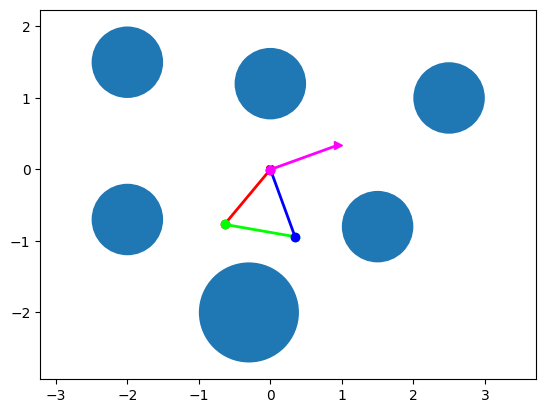

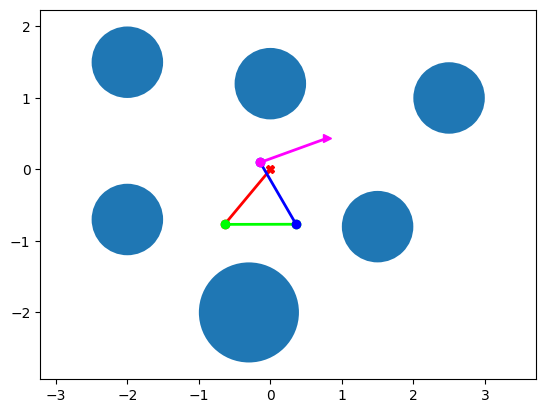

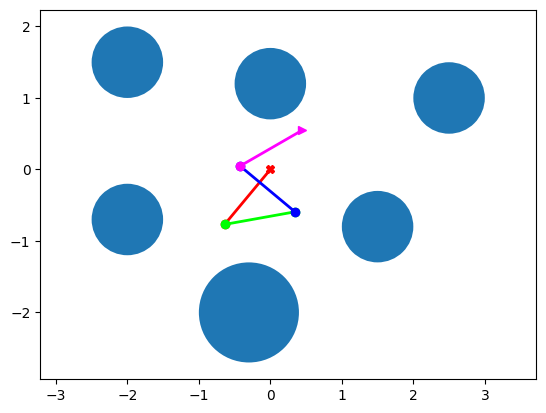

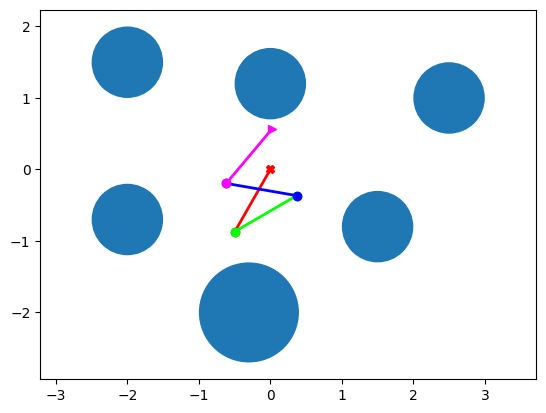

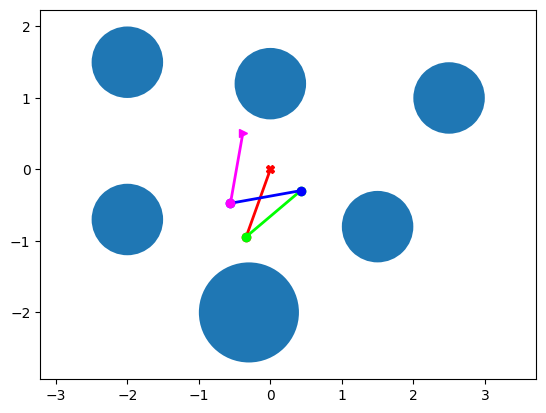

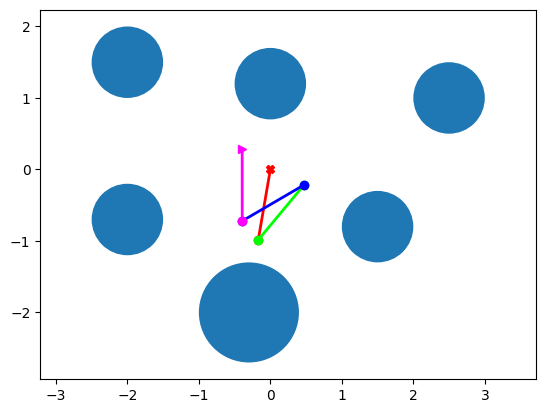

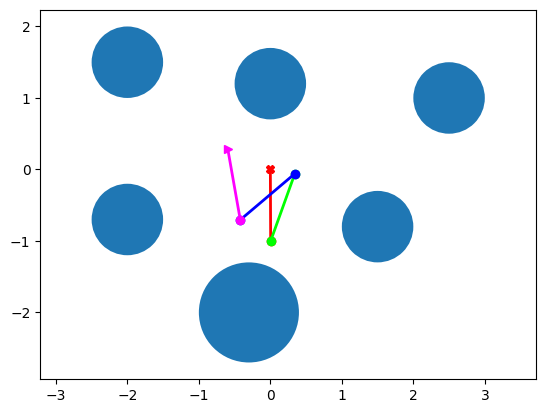

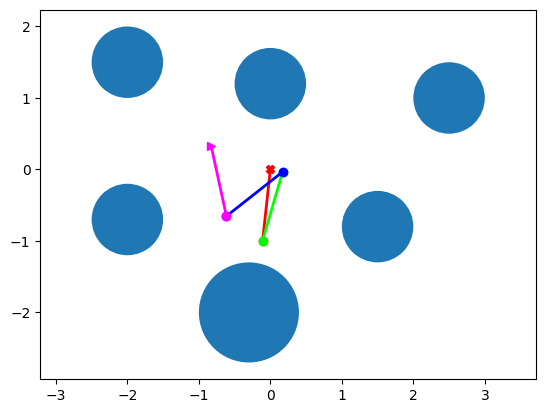

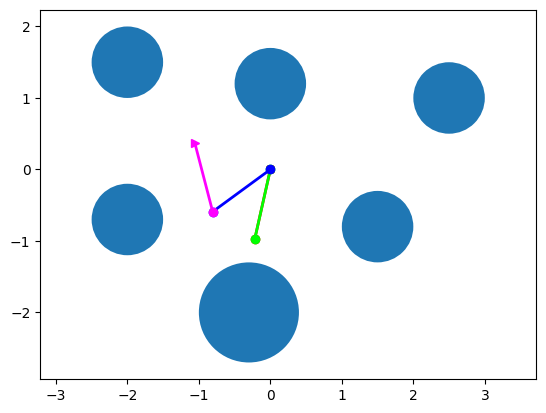

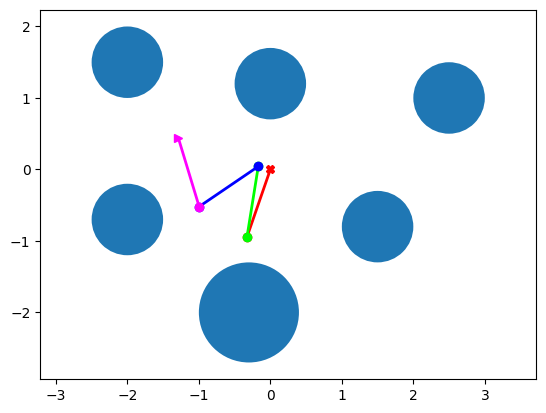

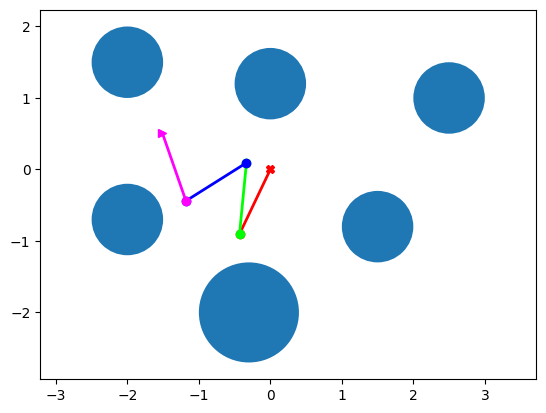

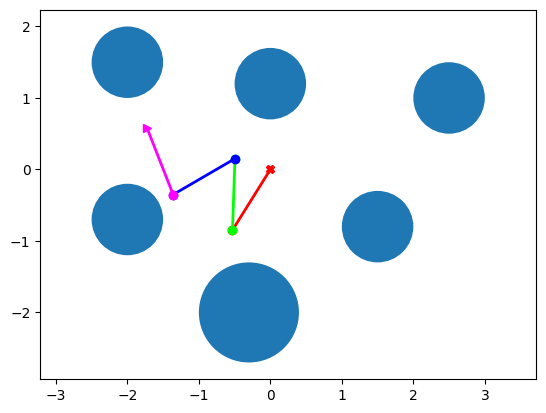

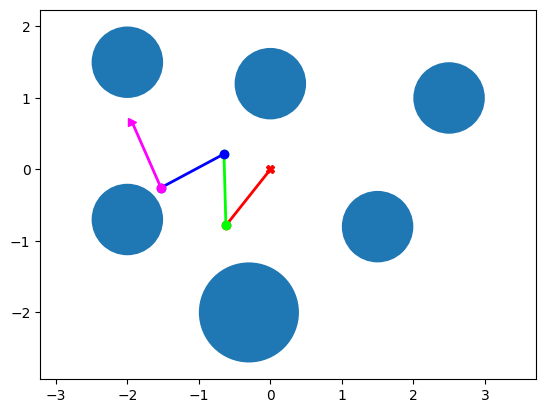

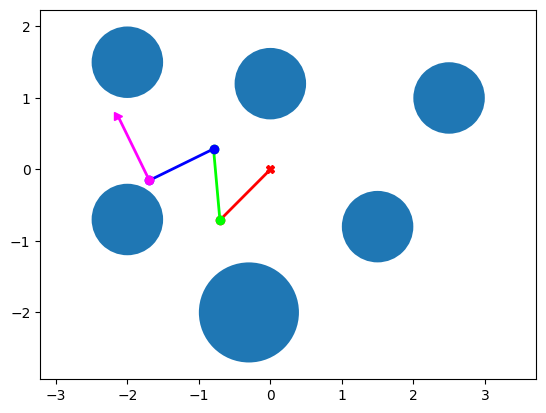

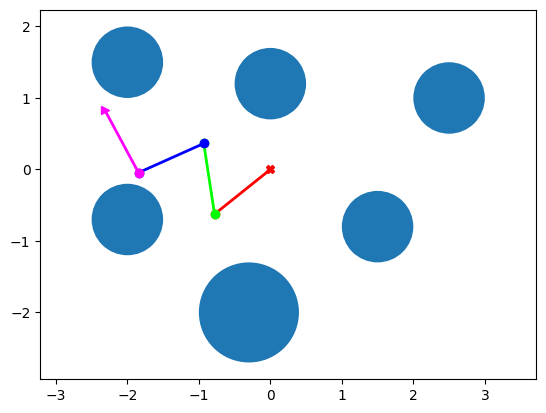

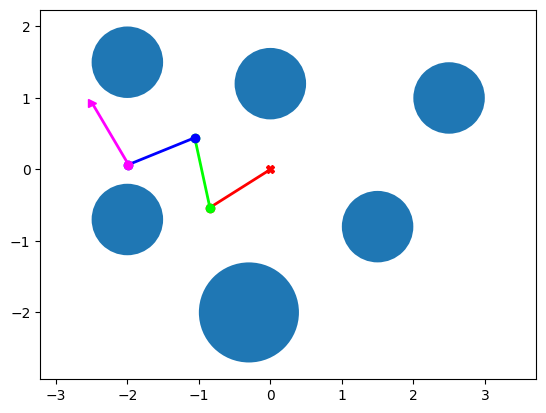

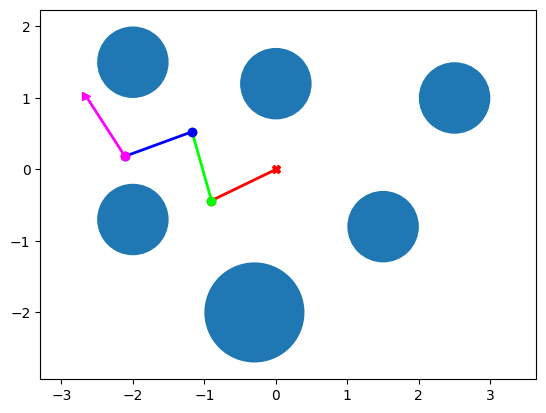

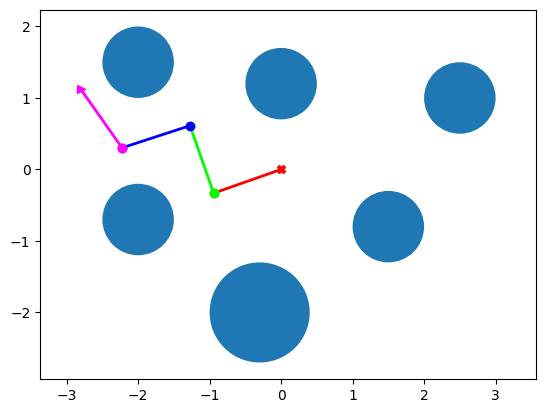

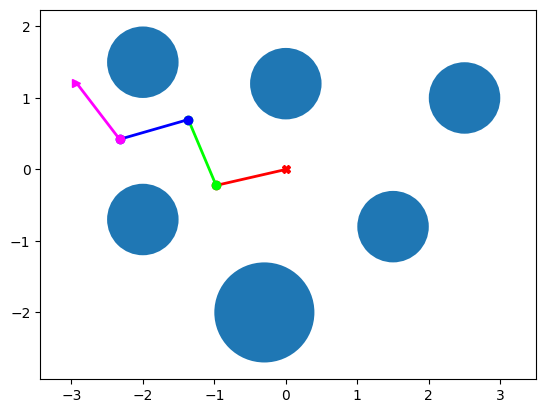

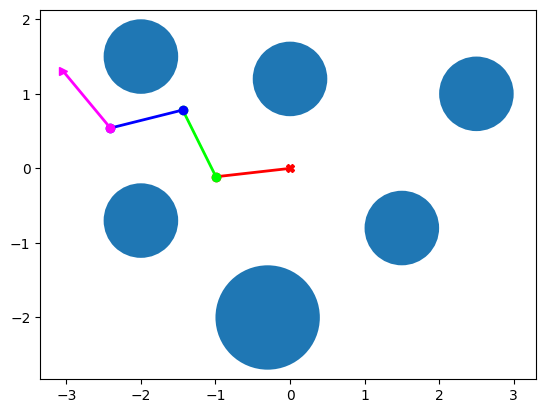

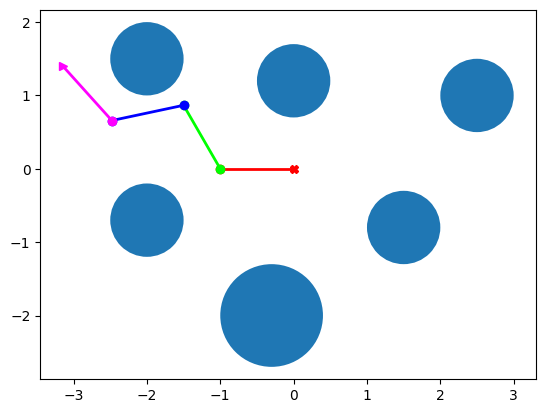

In [11]:
from typing import List, Callable

import numpy as np

from environment import State, ManipulatorEnv
import angle_util

import numpy as np
import pickle
from environment import State, ManipulatorEnv
from rrt import RRTPlanner
from video_util import animate_plan

class RRTPlanner:

    def __init__(self,
                 env: ManipulatorEnv,
                 distance_fn: Callable,
                 max_angle_step: float = 10.0):
        """
        :param env: manipulator environment
        :param distance_fn: function distance_fn(state1, state2) -> float
        :param max_angle_step: max allowed step for each joint in degrees
        """
        self._env = env
        self._distance_fn = distance_fn
        self._max_angle_step = max_angle_step

    
    def find_nearest(self,
                     q_rand,
                     G: List,
                     ):


        dist_min = 1000000
        near = []

        for i in G:
            if self._distance_fn(i[1], q_rand) < dist_min:
                dist_min = self._distance_fn(i[1], q_rand)
                near = i[1]       


        return near

    
    def steer(self,
              q_rand,
              q_near,
              ):
        
        s = 0.01
        T = False
        a = []
        for i in range(4):
            
            if angle_difference(q_rand[i], q_near[i]) > self._max_angle_step:
                a.append(self._max_angle_step)
            elif angle_difference(q_rand[i], q_near[i]) < -self._max_angle_step:
                a.append(-self._max_angle_step)
            else:
                a.append(angle_difference(q_rand[i], q_near[i]) * s)
            
            if q_near[i] + a[i] > 180:
                if len(a) == i+1:
                    a[i] = q_near[i] % 180 - 180
                else:
                    a.append(q_near[i] % 180 - 180)
            elif q_near[i] + a[i] < -180:
                if len(a) == i+1:
                    a[i] = q_near[i] % 180
                else:
                    a.append(q_near[i] % 180)
        return tuple(np.array(q_near) + a)

    
    
    def check_reach(
            self,
            q_new,
            start_state,
            goal_state,
            env: ManipulatorEnv,
            ):
        a = angle_difference(np.array(goal_state), np.array(q_new))
        if (a > -10).all() and (a < 10).all():
            if env.check_collision(State(q_new)) == False:
                return True, q_new
            
        else:
            b = int(max(abs(a // 10)))
            c = []
            result = angle_linspace(np.array(q_new), np.array(goal_state), b)
            
            
            for i in result:
                if env.check_collision(State(i)) == False:
                    c.append(i)
            if len(c) == len(result):
                return True, c
            
        return False, q_new


    def returning(
        self,
        start_state,
        goal_state,
        G: List,
        counter: int,
    ):
        s = []
        parent = []
        child = []
        
        for i in G:
            parent.append(tuple(i[1]))
            child.append(tuple(i[0]))

        
        a = child[-1] # child
        b = parent[-1] # parent
        c = [State(np.array(b))]
        
        T = True
        while (np.array(a) != start_state).any():
            b = a
            a = child[parent.index(a)]
            c.append(State(np.array(b)))
        c.append(State(np.array(b)))
        c.append(State(np.array(start_state)))
        c.reverse()
        print(f"There have been visited {counter} states")
        return c
    
    
    def plan(self,
             start_state: State,
             goal_state: State,
             samples: List,
             N: int,
             env: ManipulatorEnv,
             ):
        
        G = [(start_state.angles, start_state.angles)]
        counter = 1

        for i in range(N):
            q_rand = samples[i]

            q_near = self.find_nearest(q_rand, G)

            q_new = self.steer(q_rand, q_near)
            
            if env.check_collision(State(np.array(q_new))) == False:
                counter += 1
                G.append((q_near, q_new))
                
            T = False
            T, curr_item = self.check_reach(q_new, start_state.angles, goal_state.angles, env)
            if T == True:
                if type(curr_item) != list:
                    G.append((q_new, goal_state))
                    counter += 1
                else:
                    for i in range(1, len(curr_item)):
                        G.append((curr_item[i-1], curr_item[i]))
                        counter += 1
                return self.returning(start_state.angles, goal_state.angles, G, counter)
        
        return 0



def sampling(N):
    return np.random.uniform(low=-180.0, high=180.0, size=(N, 4))


def distance_func(vec_1, vec_2):
    return np.linalg.norm(vec_1 - vec_2, ord=1)



def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
    print(data)
    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=start_state,
                         collision_threshold=data["collision_threshold"])
    N = 4000
    samples = sampling(N)
    
    planner = RRTPlanner(env, distance_func)
    
    plan = planner.plan(start_state, goal_state, samples, N, env)
    print("The plan length:", len(plan)-1)
    animate_plan(env, plan)

if __name__ == '__main__':
    main()

## Subtask B

Comment on how many states have been visited? What is the final trajectory size? Can you
comment on the optimality of the plan? You can also collect some observations and statistics across multiple
runs.

On average, there have been visited 700 states. The final trajectory size is around 51. Obviously, the plan is not the most optimal. It can be improved via several heuristics.

## Subtask C

Try to change weight of rotation in calculation of distance between two agent positions. We suggest
you to build a distance function based on weighted sum of the angle distances. Comment on the results.

{'start_state': [0.0, 0.0, 0.0, 0.0], 'goal_state': [-180.0, -60.0, 72.0, -60.0], 'obstacles': [[2.5, 1.0, 0.5], [1.5, -0.8, 0.5], [-2, -0.7, 0.5], [-2, 1.5, 0.5], [0.0, 1.2, 0.5], [-0.3, -2.0, 0.7]], 'collision_threshold': 0.1}
There have been visited 671 states
The plan length: 70


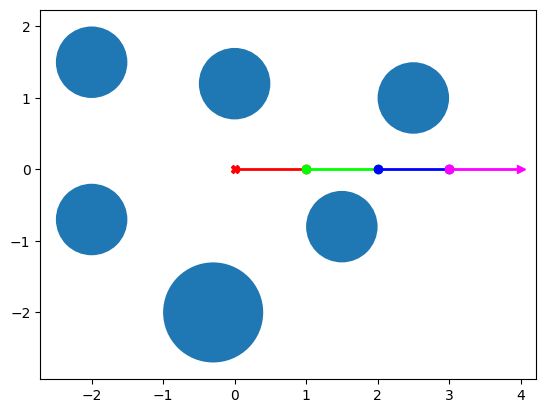

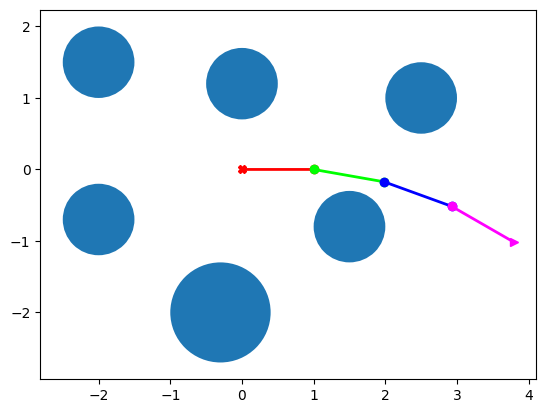

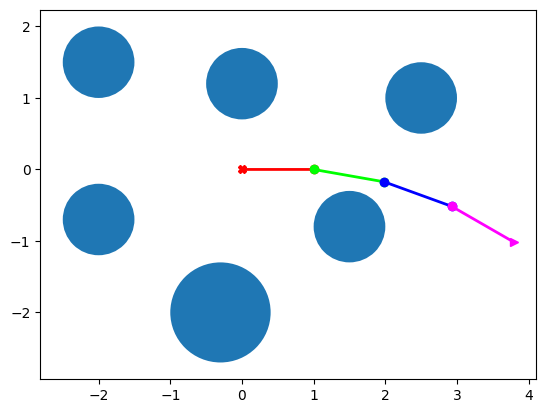

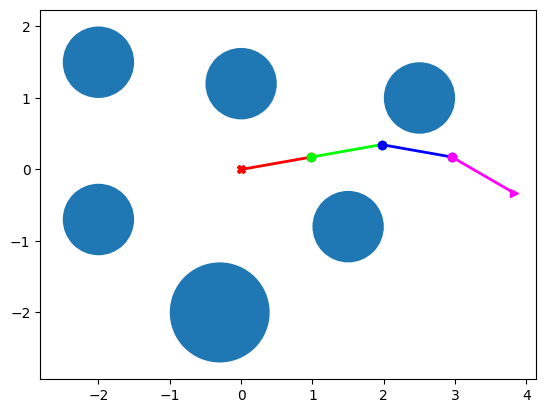

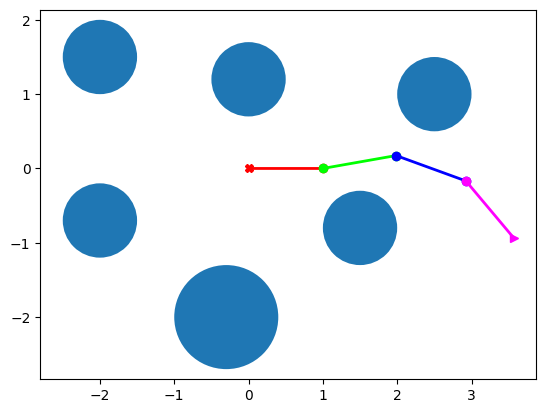

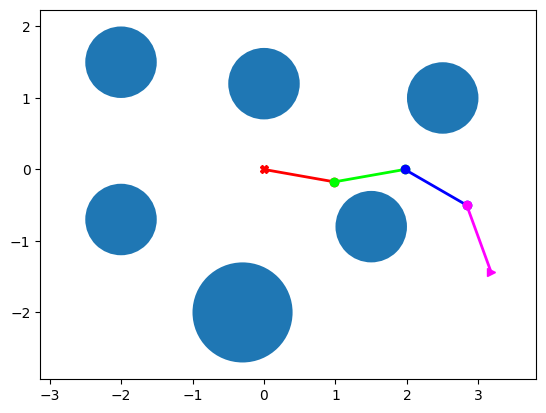

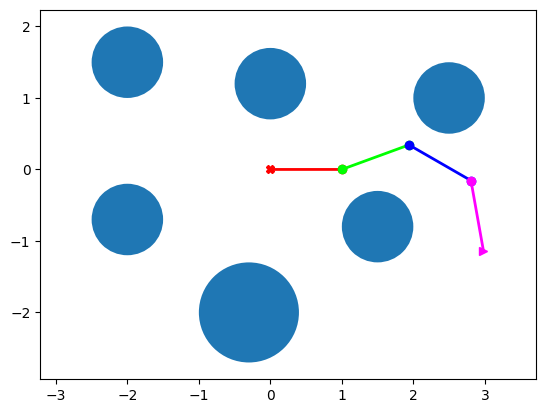

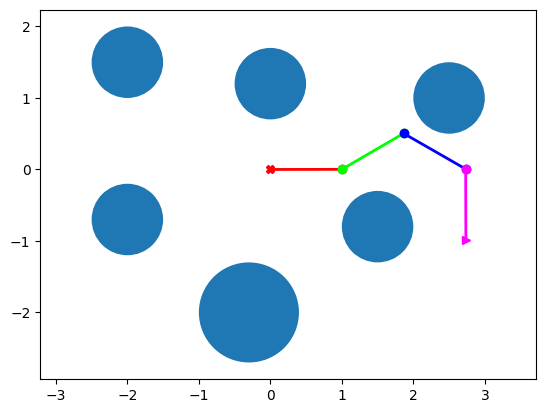

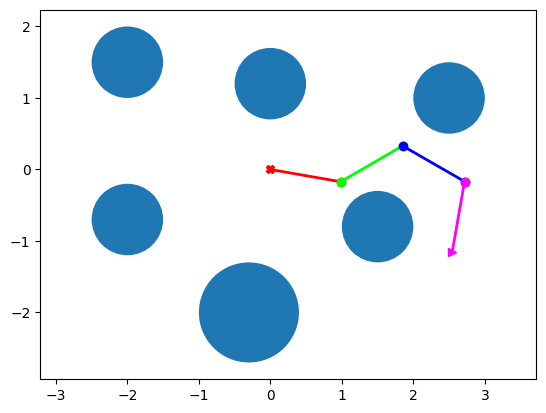

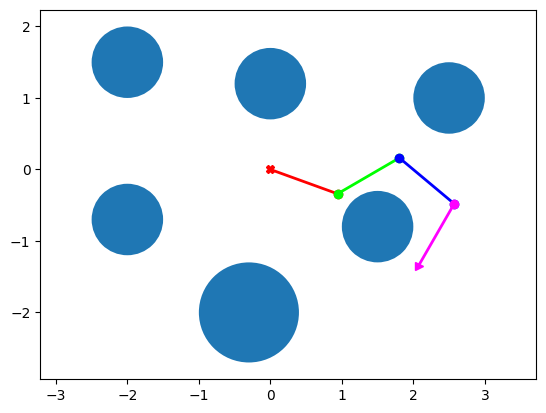

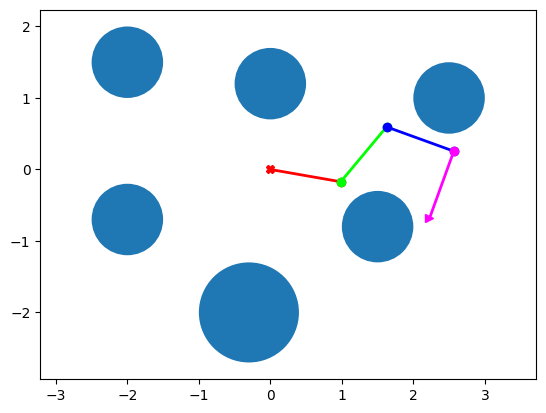

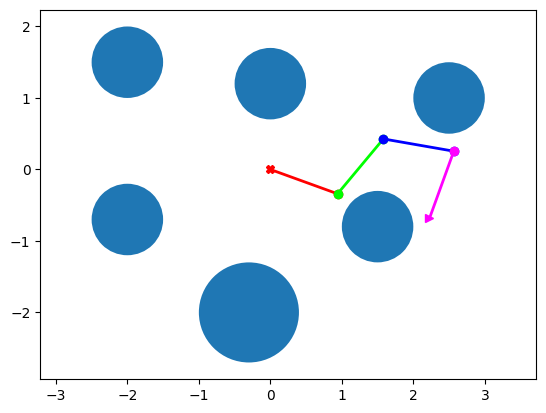

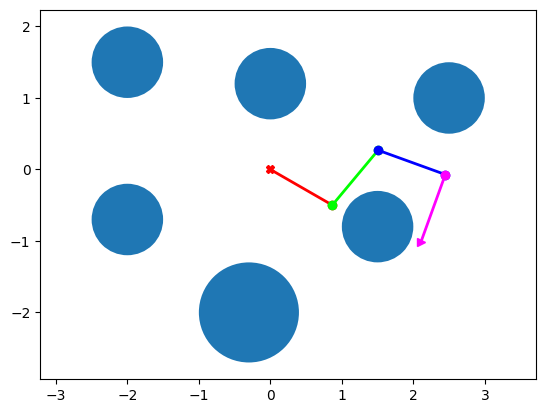

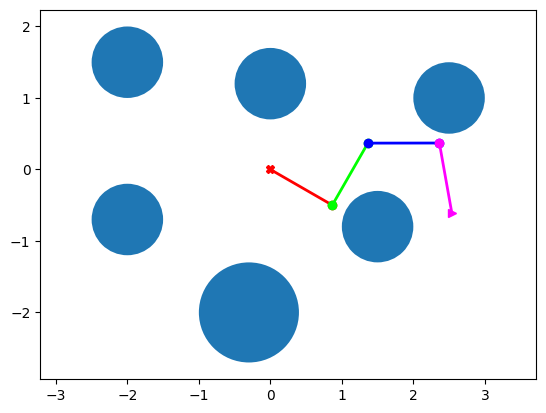

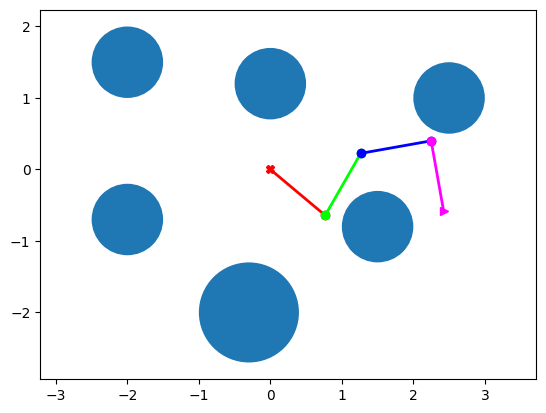

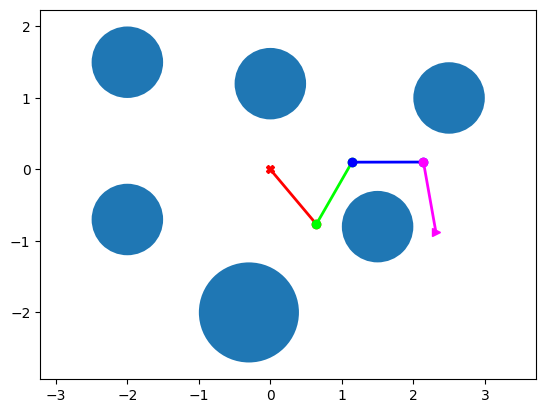

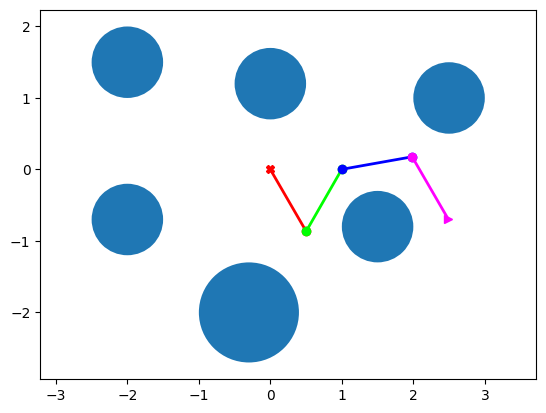

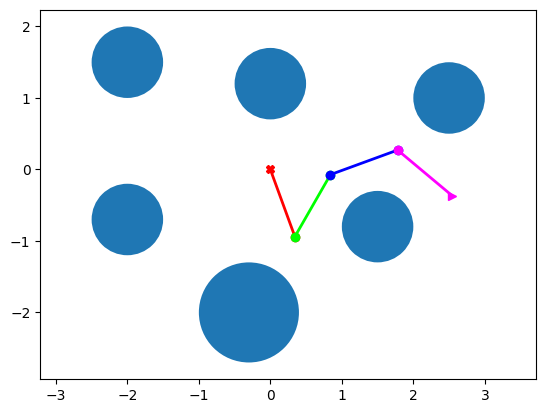

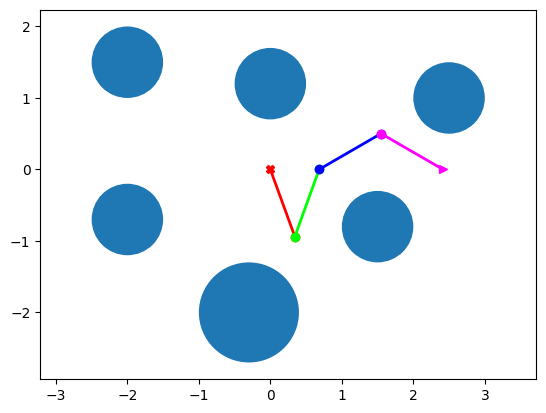

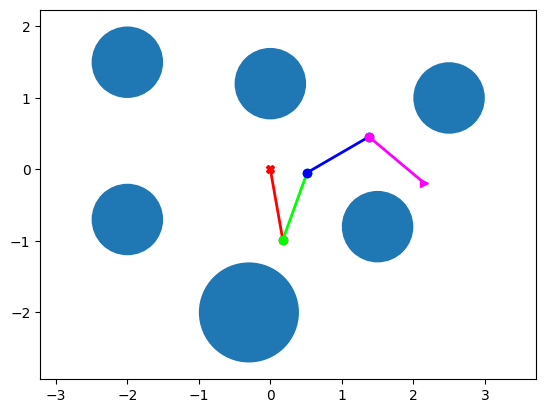

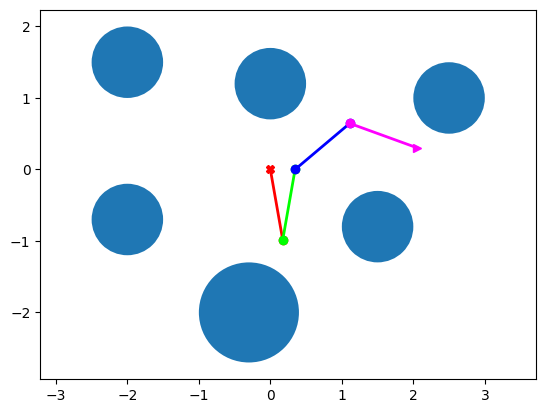

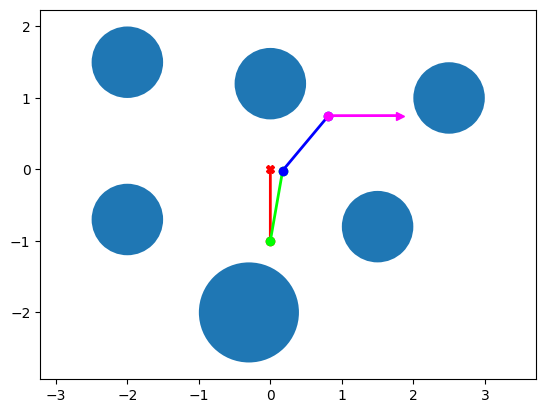

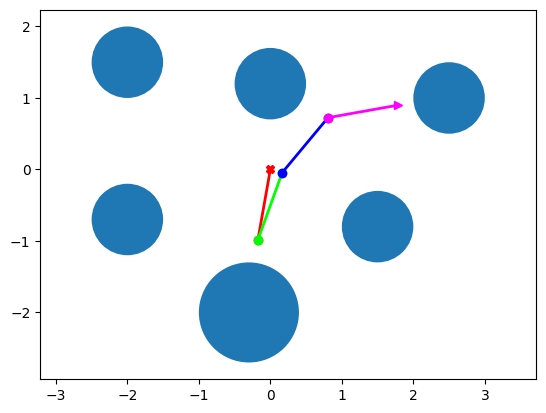

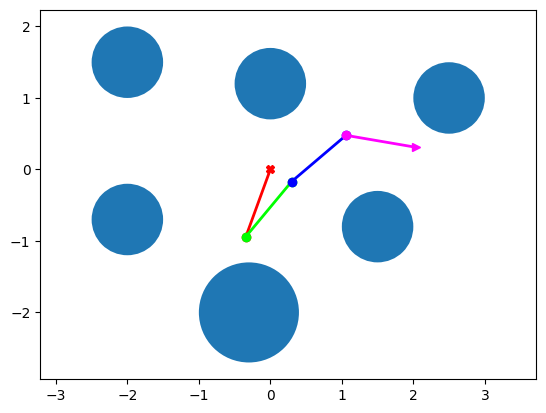

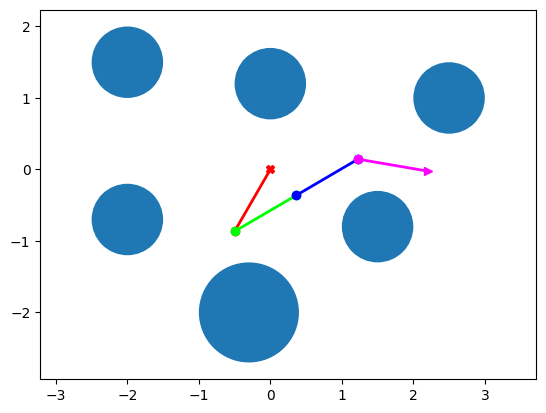

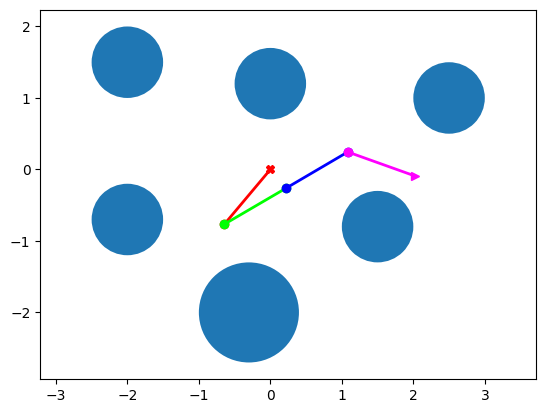

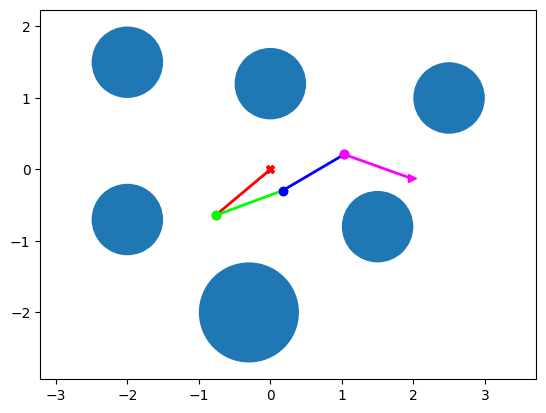

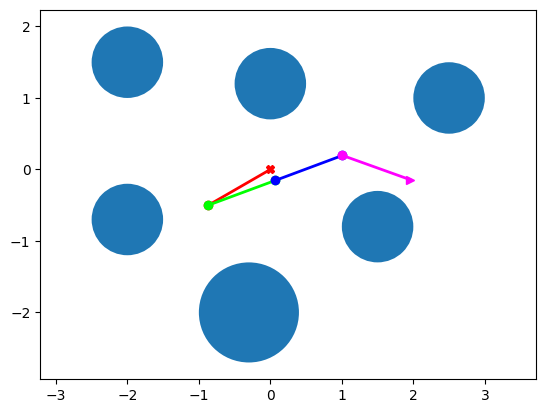

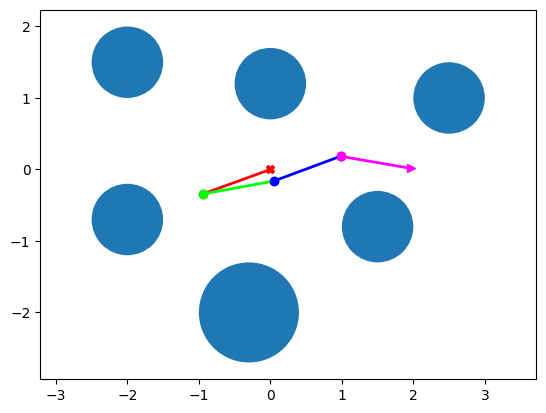

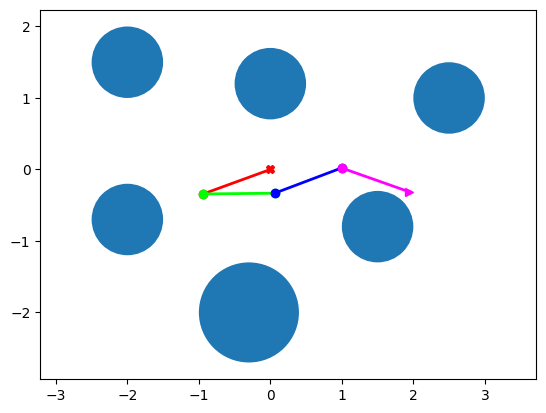

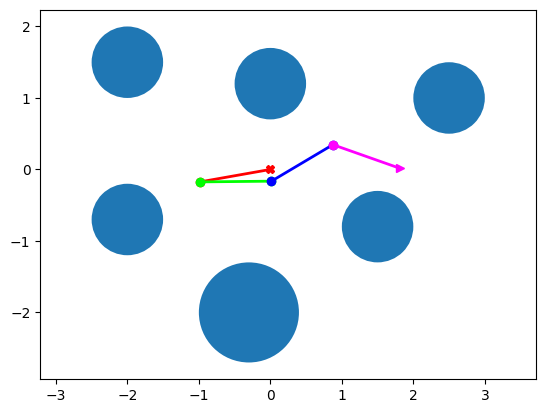

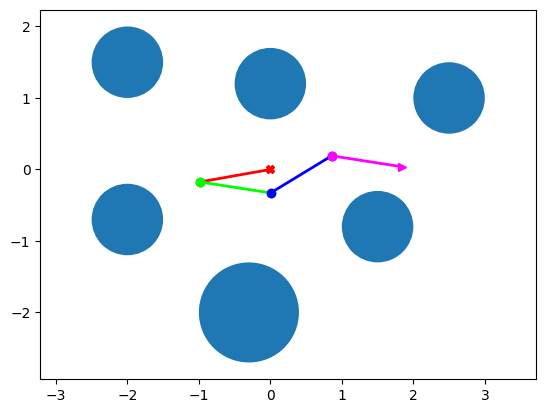

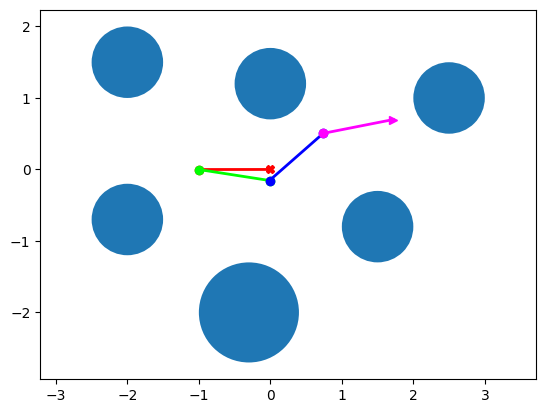

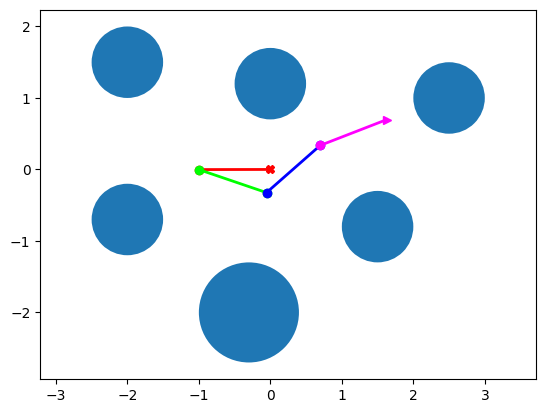

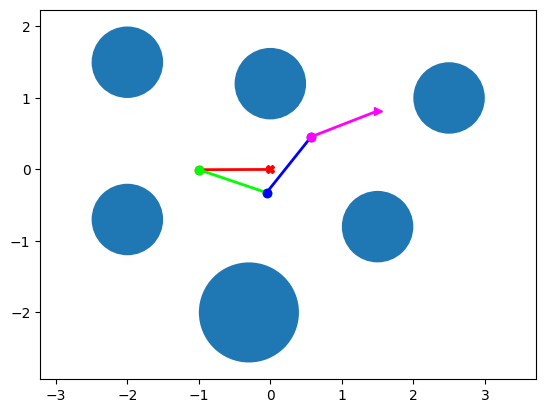

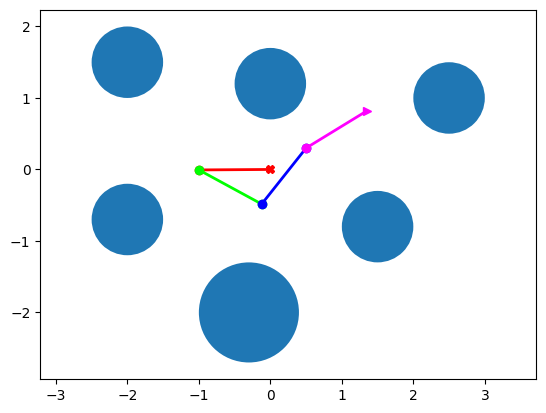

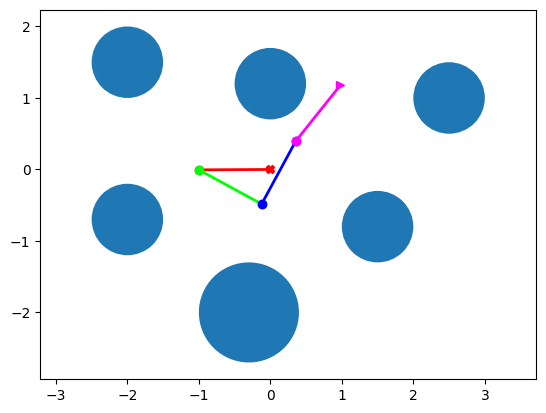

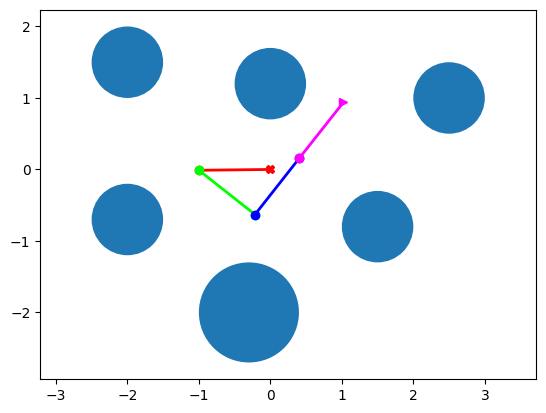

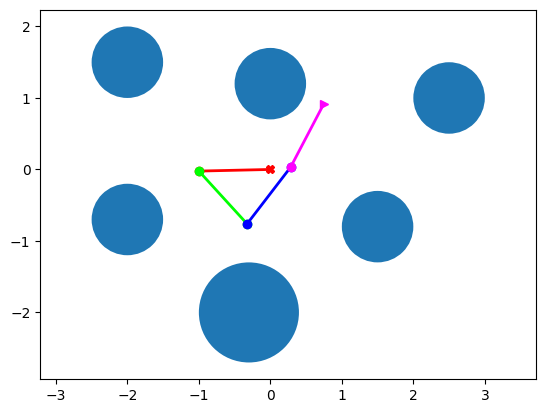

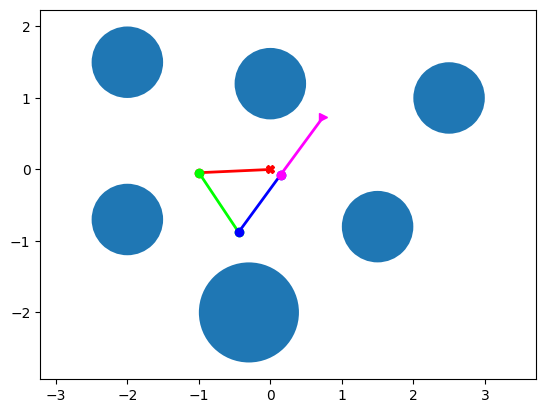

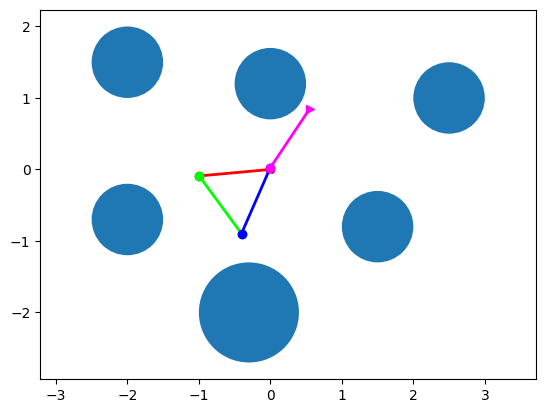

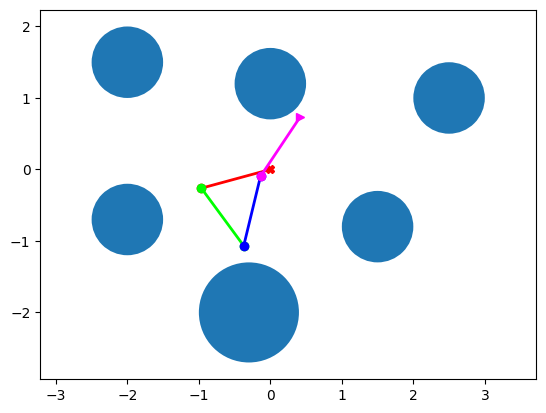

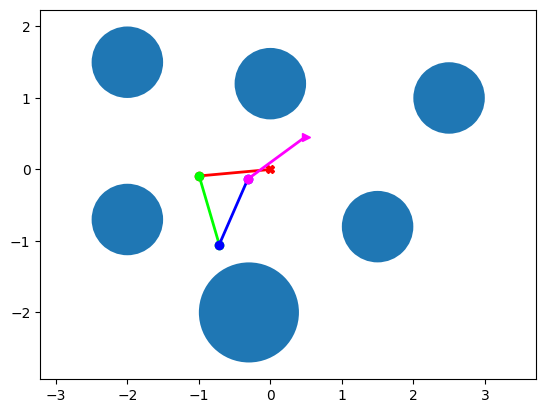

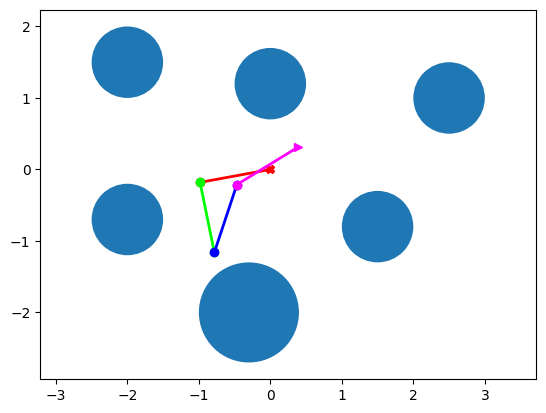

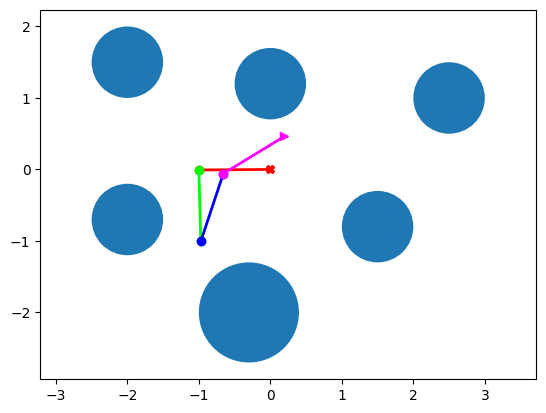

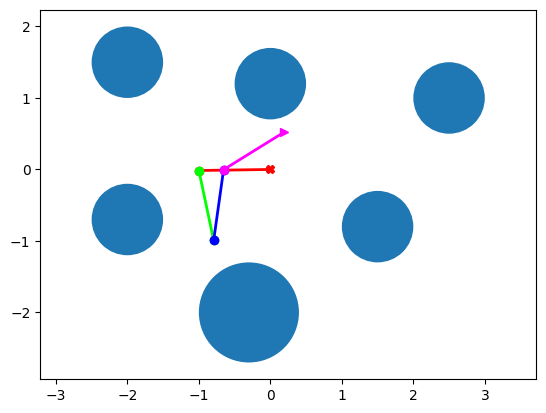

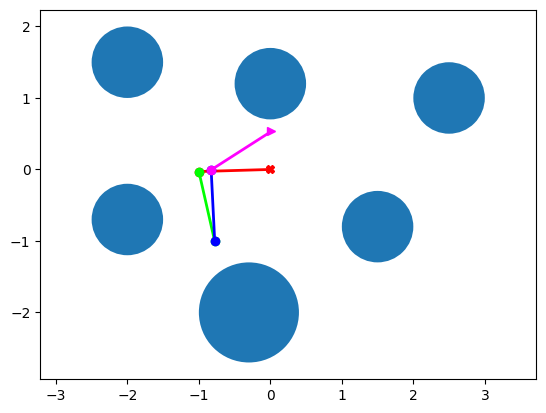

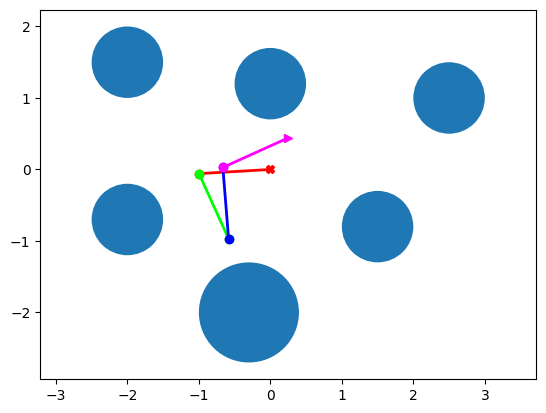

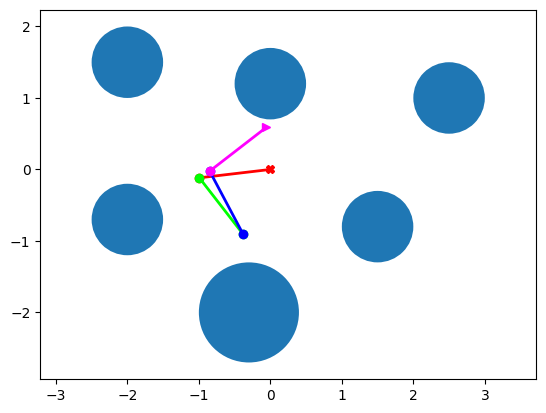

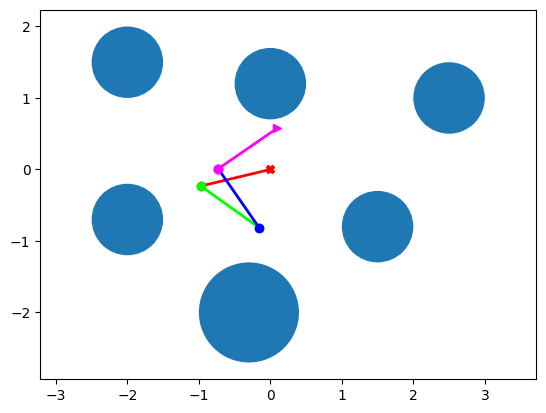

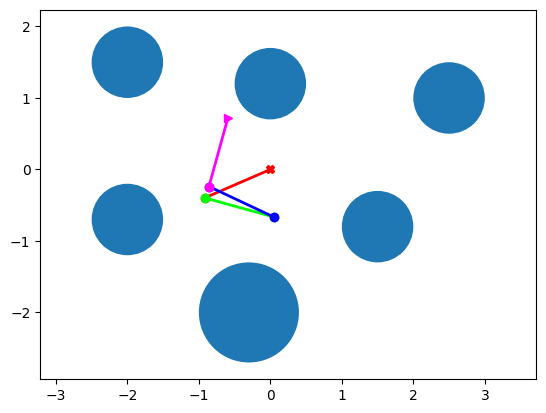

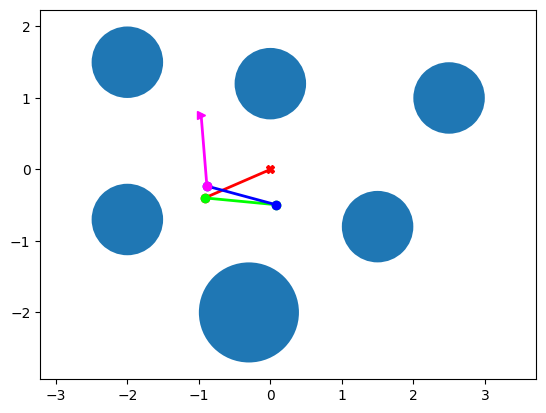

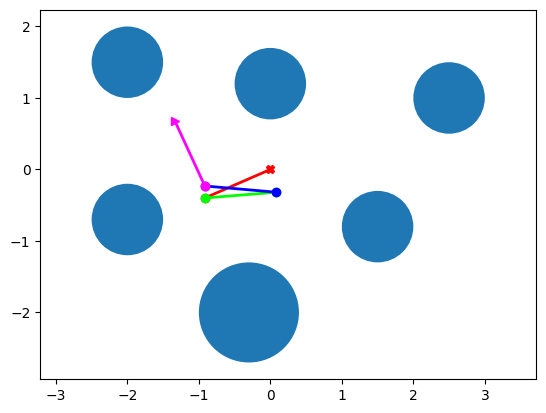

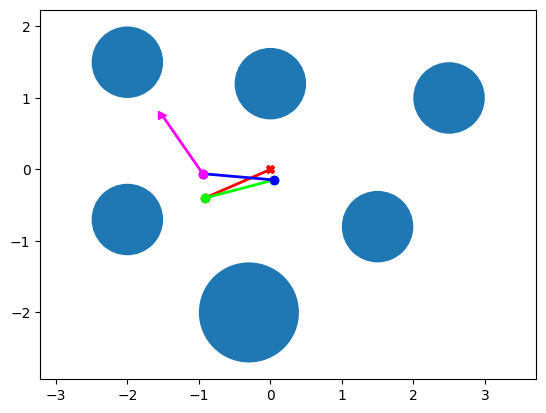

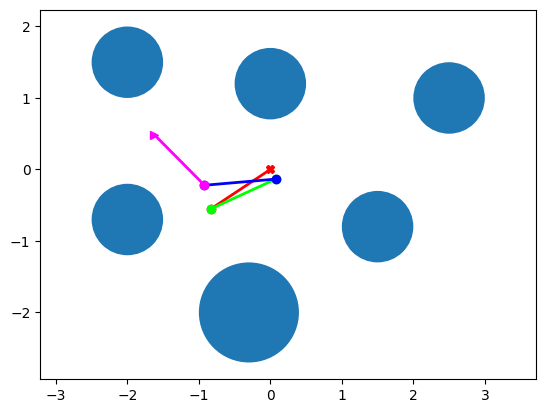

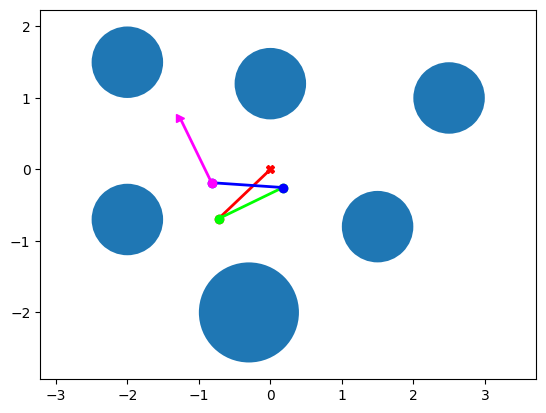

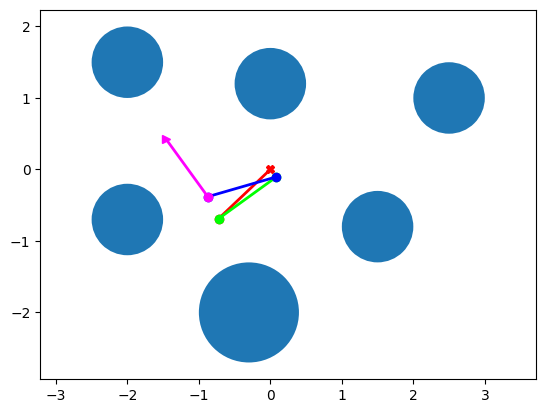

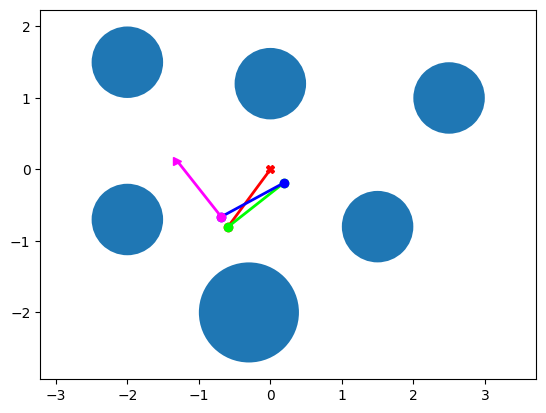

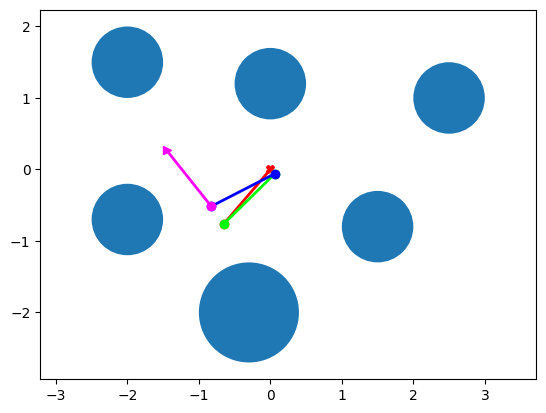

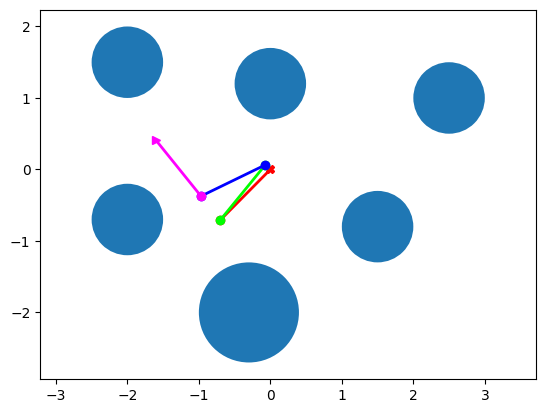

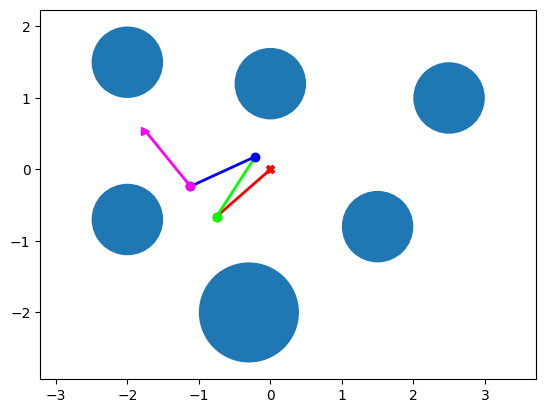

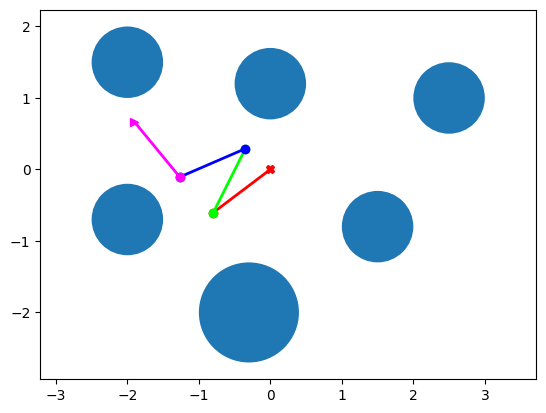

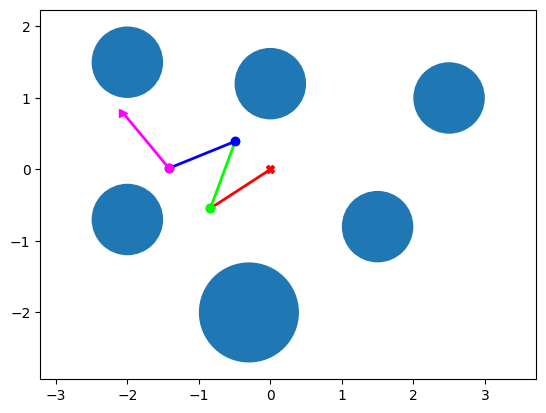

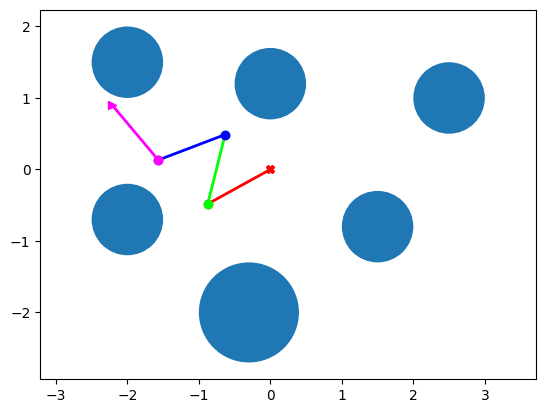

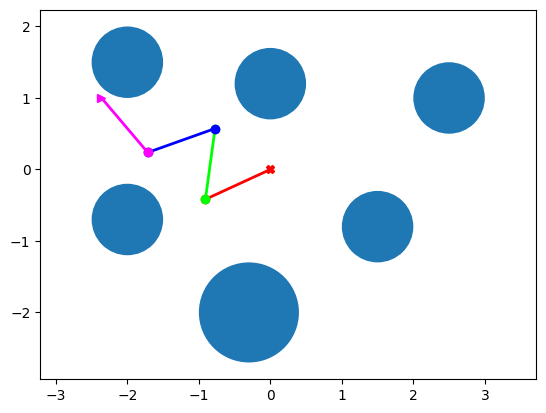

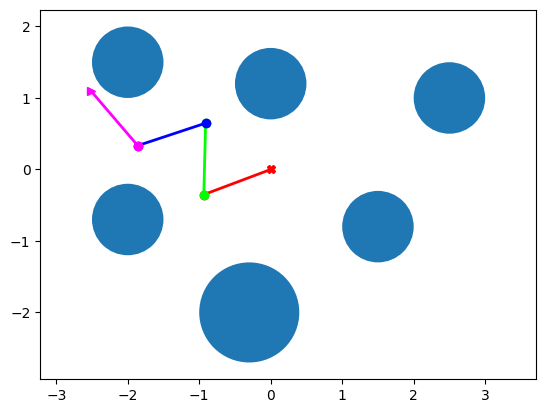

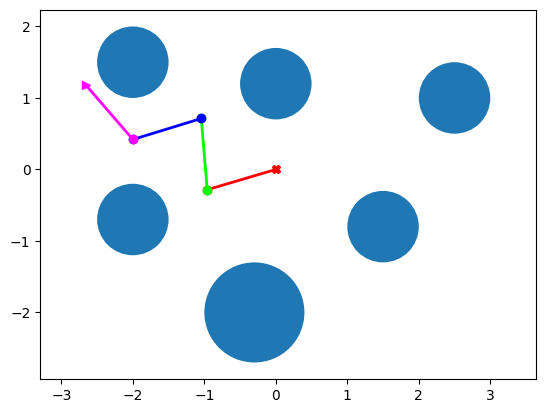

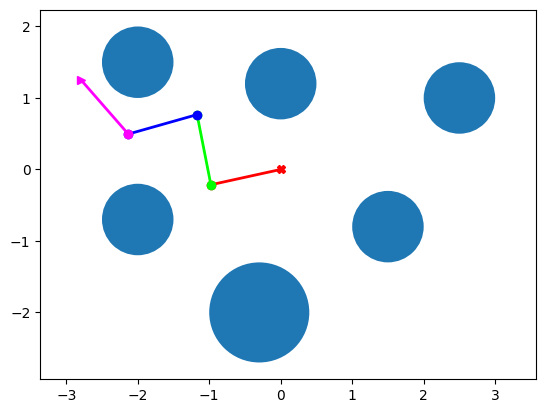

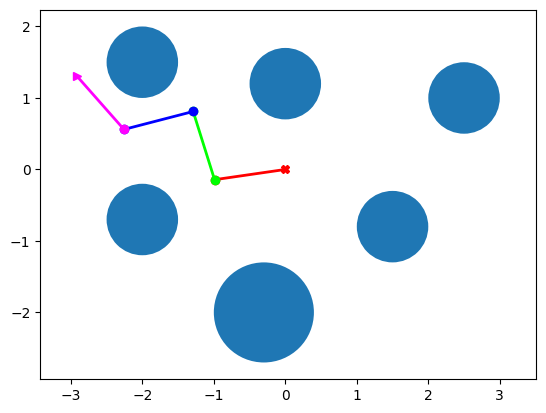

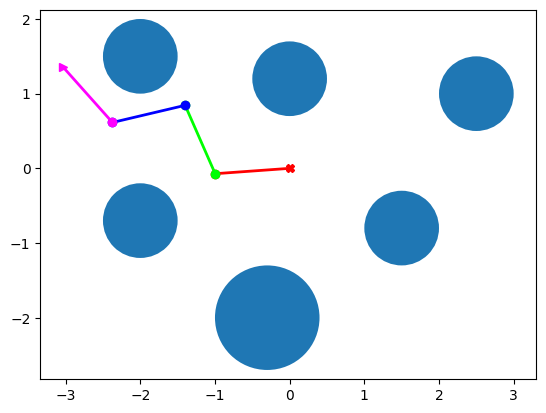

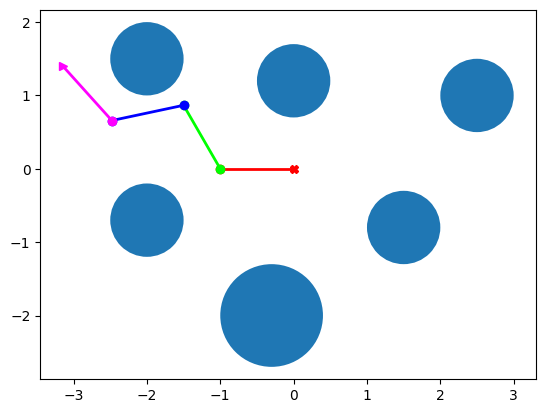

In [6]:
from typing import List, Callable

import numpy as np

from environment import State, ManipulatorEnv
import angle_util

import numpy as np
import pickle
from environment import State, ManipulatorEnv
from rrt import RRTPlanner
from video_util import animate_plan

class RRTPlanner:

    def __init__(self,
                 env: ManipulatorEnv,
                 distance_fn: Callable,
                 max_angle_step: float = 10.0):
        """
        :param env: manipulator environment
        :param distance_fn: function distance_fn(state1, state2) -> float
        :param max_angle_step: max allowed step for each joint in degrees
        """
        self._env = env
        self._distance_fn = distance_fn
        self._max_angle_step = max_angle_step

    
    def find_nearest(self,
                     q_rand,
                     G: List,
                     ):


        dist_min = 1000000
        near = []

        for i in G:
            if self._distance_fn(i[1], q_rand) < dist_min:
                dist_min = self._distance_fn(i[1], q_rand)
                near = i[1]       


        return near

    
    def steer(self,
              q_rand,
              q_near,
              ):
        
        s = 0.01
        T = False
        a = []
        for i in range(4):
            
            if angle_difference(q_rand[i], q_near[i]) > self._max_angle_step:
                a.append(self._max_angle_step)
            elif angle_difference(q_rand[i], q_near[i]) < -self._max_angle_step:
                a.append(-self._max_angle_step)
            else:
                a.append(angle_difference(q_rand[i], q_near[i]) * s)
            
            if q_near[i] + a[i] > 180:
                if len(a) == i+1:
                    a[i] = q_near[i] % 180 - 180
                else:
                    a.append(q_near[i] % 180 - 180)
            elif q_near[i] + a[i] < -180:
                if len(a) == i+1:
                    a[i] = q_near[i] % 180
                else:
                    a.append(q_near[i] % 180)
        return tuple(np.array(q_near) + a)

    
    
    def check_reach(
            self,
            q_new,
            start_state,
            goal_state,
            env: ManipulatorEnv,
            ):
        a = angle_difference(np.array(goal_state), np.array(q_new))
        if (a > -10).all() and (a < 10).all():
            if env.check_collision(State(q_new)) == False:
                return True, q_new
            
        else:
            b = int(max(abs(a // 10)))
            c = []
            result = angle_linspace(np.array(q_new), np.array(goal_state), b)
            
            
            for i in result:
                if env.check_collision(State(i)) == False:
                    c.append(i)
            if len(c) == len(result):
                return True, c
            
        return False, q_new


    def returning(
        self,
        start_state,
        goal_state,
        G: List,
        counter: int,
    ):
        s = []
        parent = []
        child = []
        
        for i in G:
            parent.append(tuple(i[1]))
            child.append(tuple(i[0]))

        
        a = child[-1] # child
        b = parent[-1] # parent
        c = [State(np.array(b))]
        
        T = True
        while (np.array(a) != start_state).any():
            b = a
            a = child[parent.index(a)]
            c.append(State(np.array(b)))
        c.append(State(np.array(b)))
        c.append(State(np.array(start_state)))
        c.reverse()
        print(f"There have been visited {counter} states")
        return c
    
    
    def plan(self,
             start_state: State,
             goal_state: State,
             samples: List,
             N: int,
             env: ManipulatorEnv,
             ):
        
        G = [(start_state.angles, start_state.angles)]
        counter = 1

        for i in range(N):
            q_rand = samples[i]

            q_near = self.find_nearest(q_rand, G)

            q_new = self.steer(q_rand, q_near)
            
            if env.check_collision(State(np.array(q_new))) == False:
                counter += 1
                G.append((q_near, q_new))
                
            T = False
            T, curr_item = self.check_reach(q_new, start_state.angles, goal_state.angles, env)
            if T == True:
                if type(curr_item) != list:
                    G.append((q_new, goal_state))
                    counter += 1
                else:
                    for i in range(1, len(curr_item)):
                        G.append((curr_item[i-1], curr_item[i]))
                        counter += 1
                return self.returning(start_state.angles, goal_state.angles, G, counter)
        
        return 0



def sampling(N):
    return np.random.uniform(low=-180.0, high=180.0, size=(N, 4))


def distance_func(vec_1, vec_2):
    return np.dot(np.abs(angle_difference(np.array(vec_2), np.array(vec_1))), np.array([8,6,4,2]))



def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
    print(data)
    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=start_state,
                         collision_threshold=data["collision_threshold"])
    N = 4000
    samples = sampling(N)
    
    planner = RRTPlanner(env, distance_func)
    
    plan = planner.plan(start_state, goal_state, samples, N, env)
    print("The plan length:", len(plan)-1)
    animate_plan(env, plan)

if __name__ == '__main__':
    main()

The plan length became larger.

## Subtask D

 Try to change step size used for RRT branches. Comment on the results.

{'start_state': [0.0, 0.0, 0.0, 0.0], 'goal_state': [-180.0, -60.0, 72.0, -60.0], 'obstacles': [[2.5, 1.0, 0.5], [1.5, -0.8, 0.5], [-2, -0.7, 0.5], [-2, 1.5, 0.5], [0.0, 1.2, 0.5], [-0.3, -2.0, 0.7]], 'collision_threshold': 0.1}
There have been visited 360 states
The plan length: 57


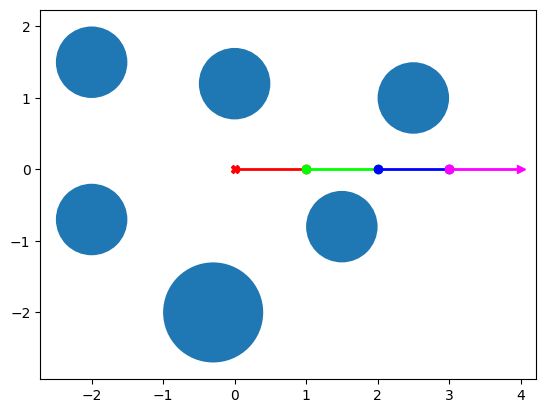

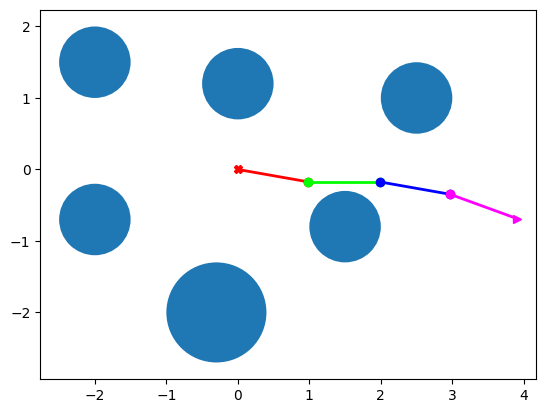

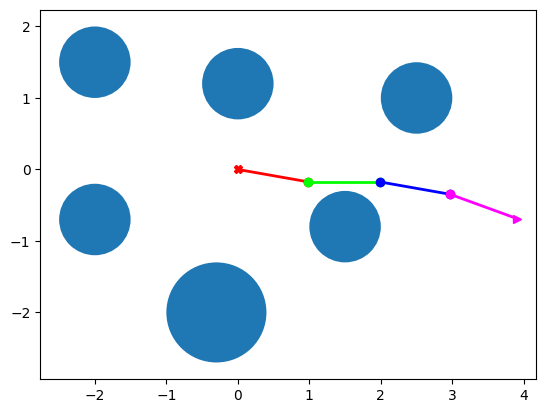

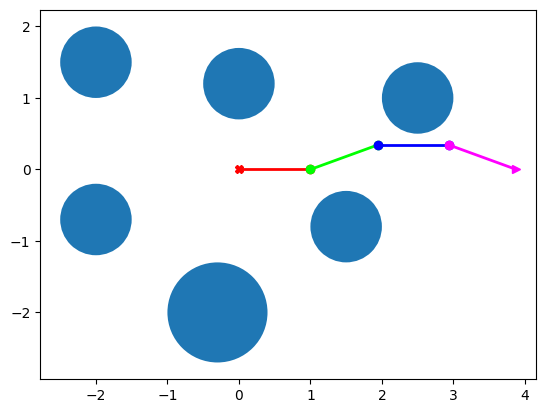

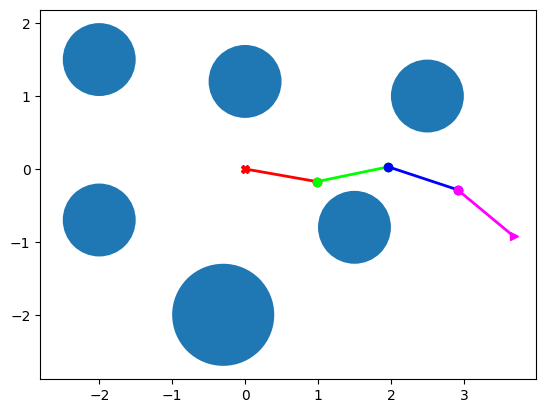

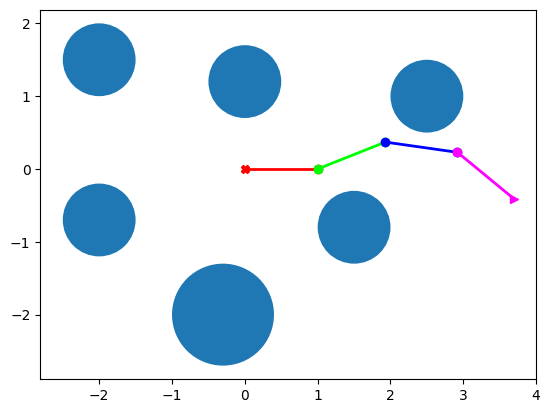

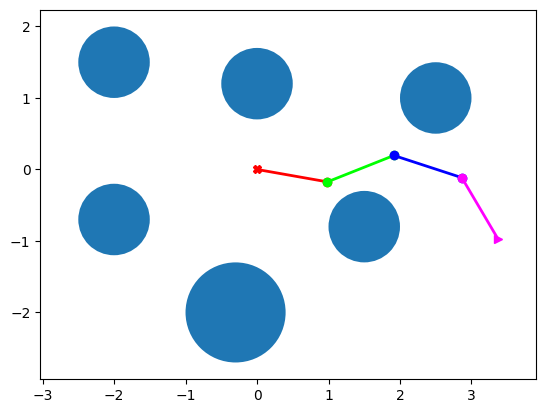

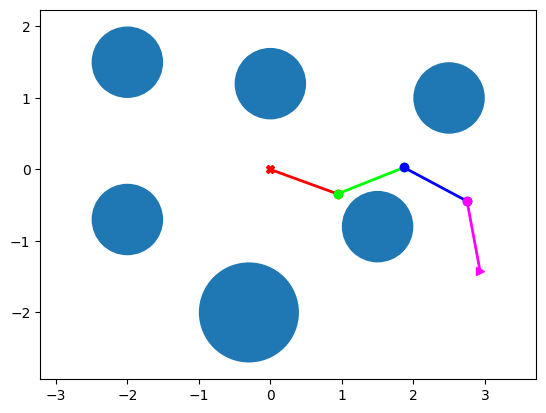

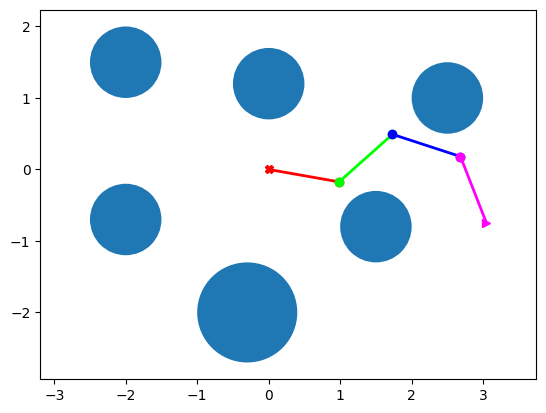

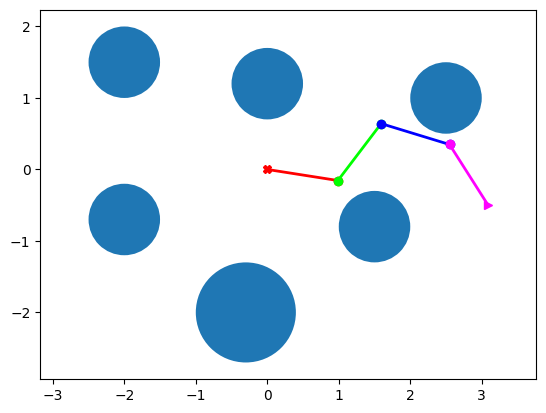

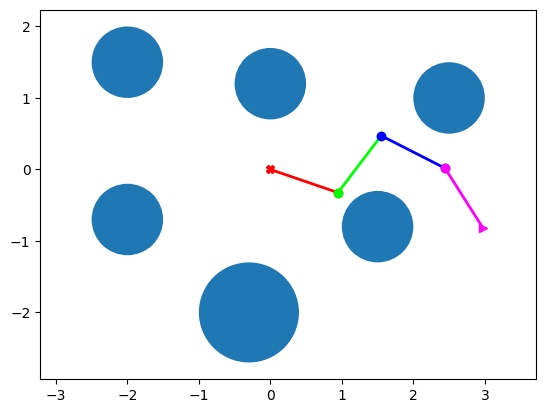

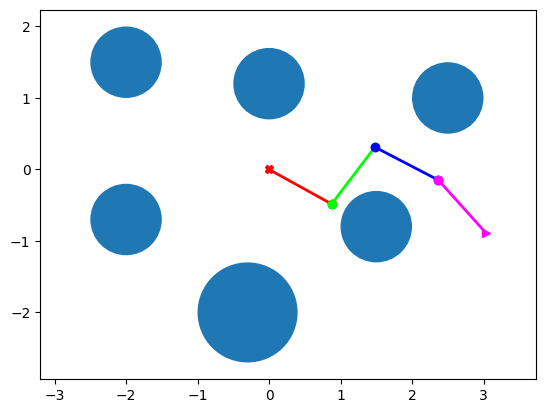

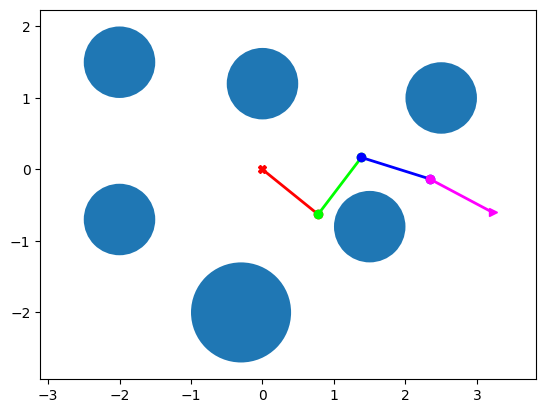

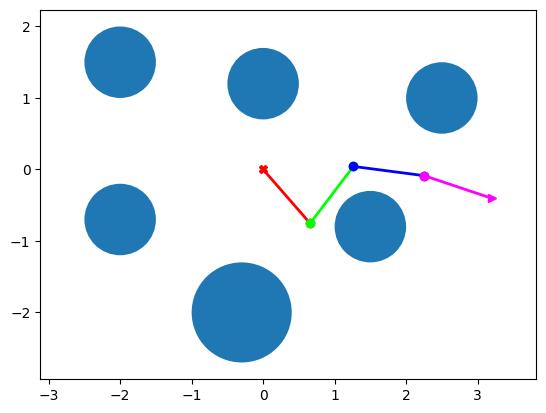

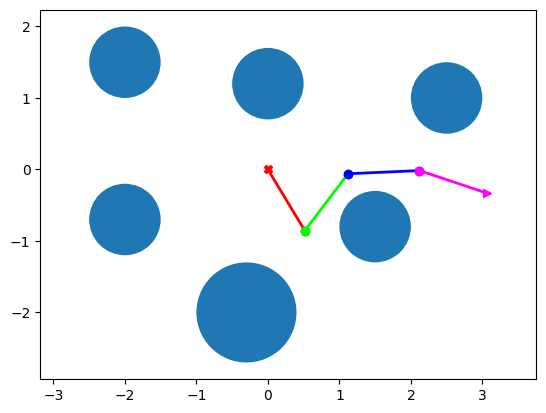

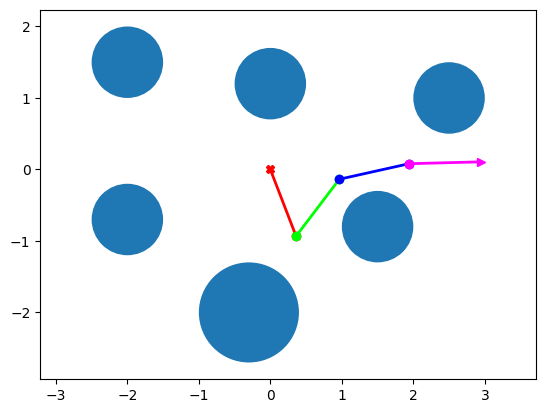

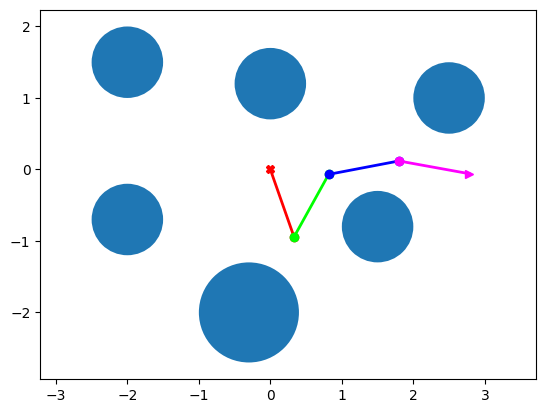

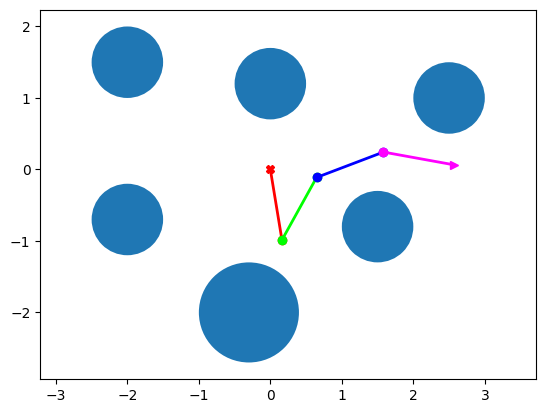

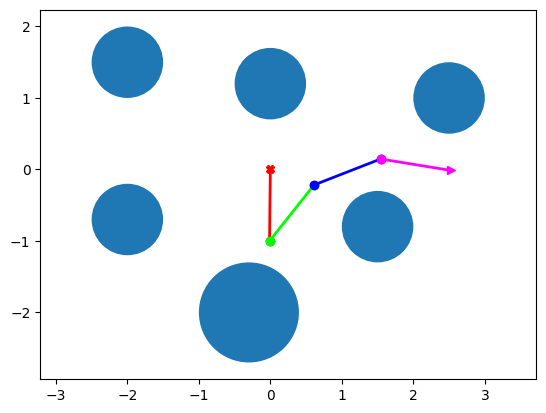

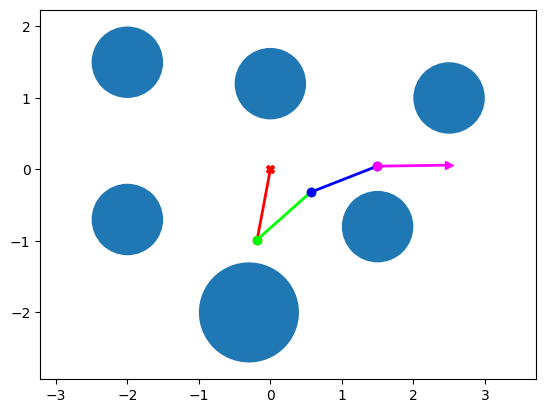

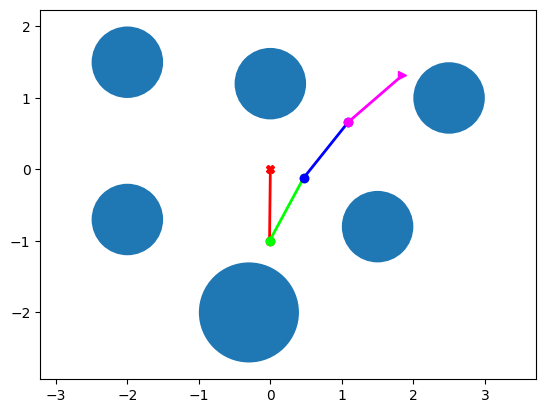

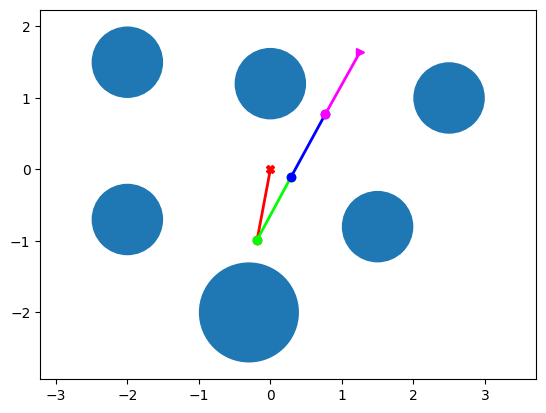

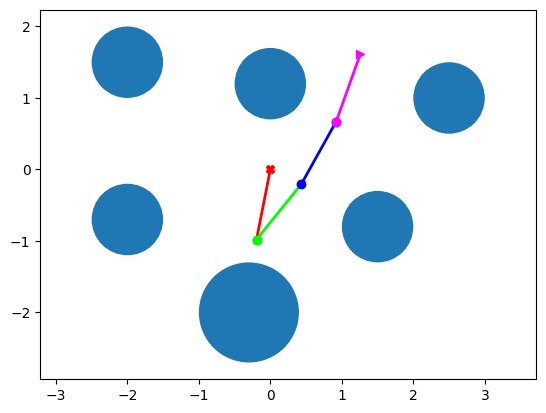

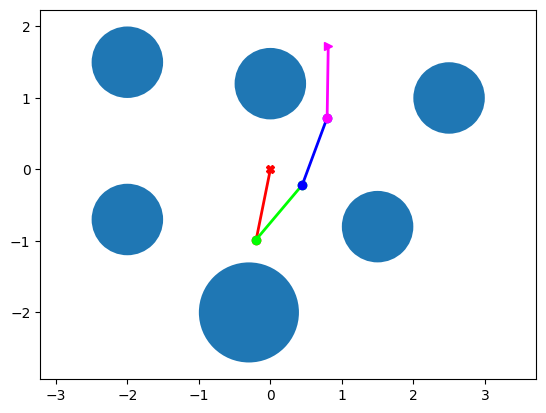

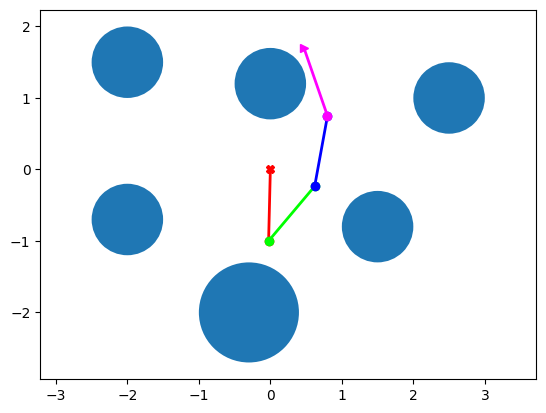

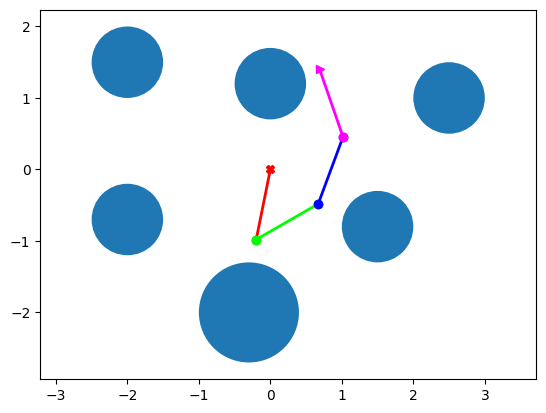

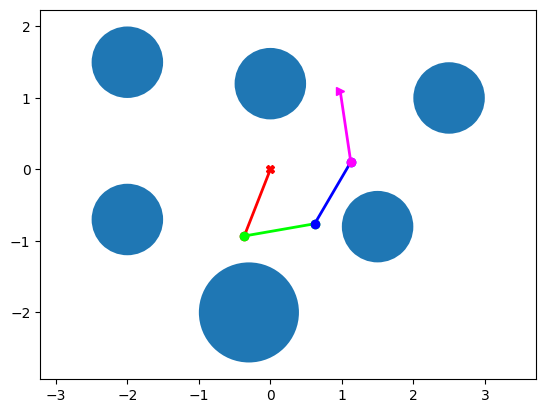

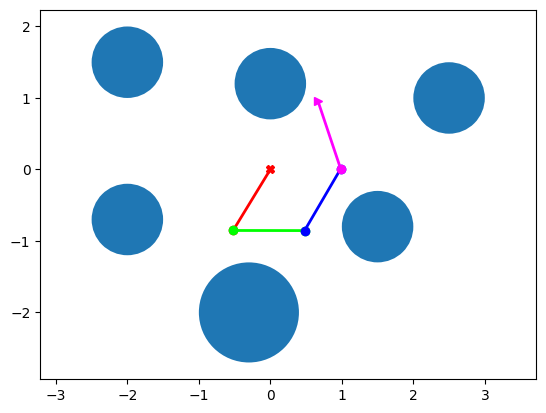

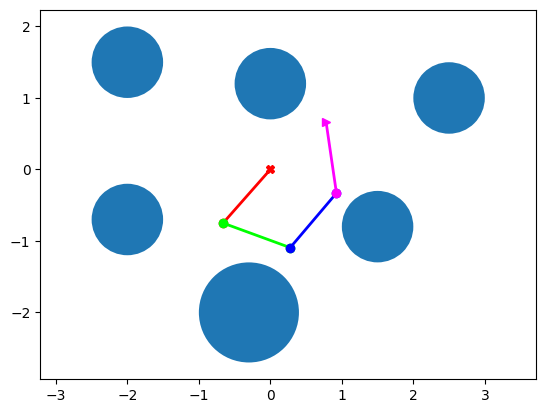

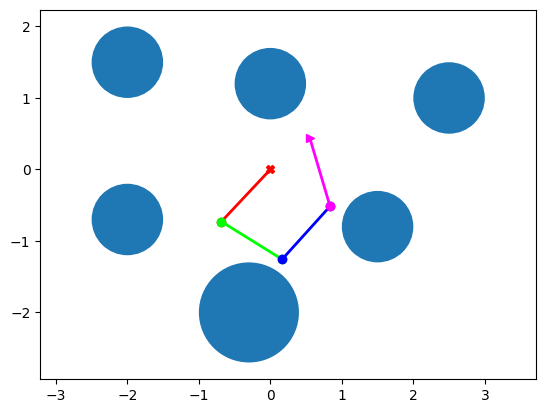

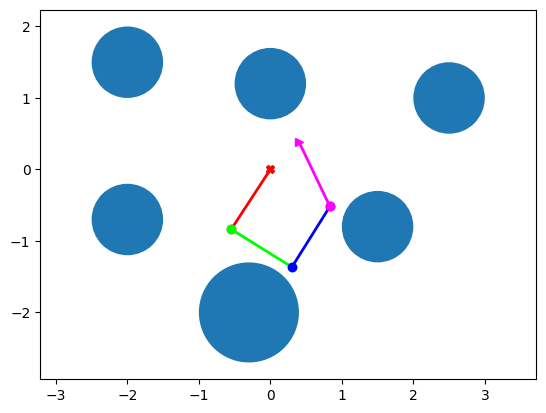

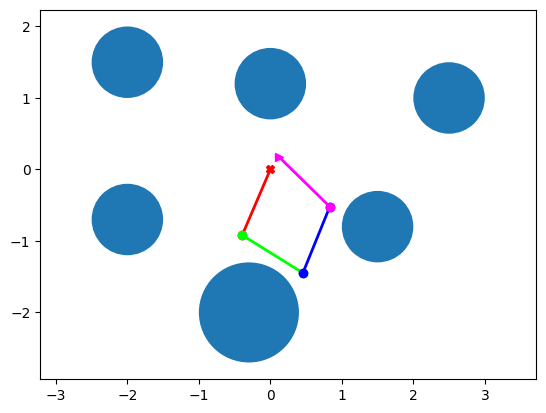

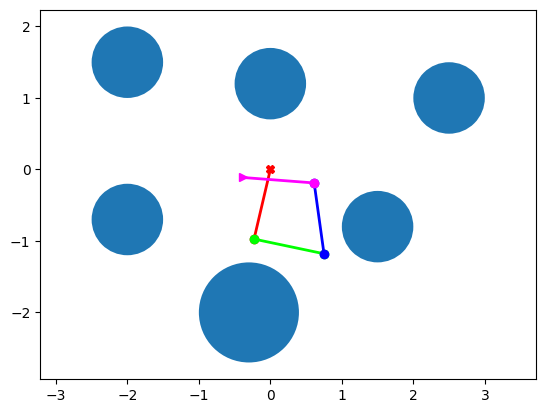

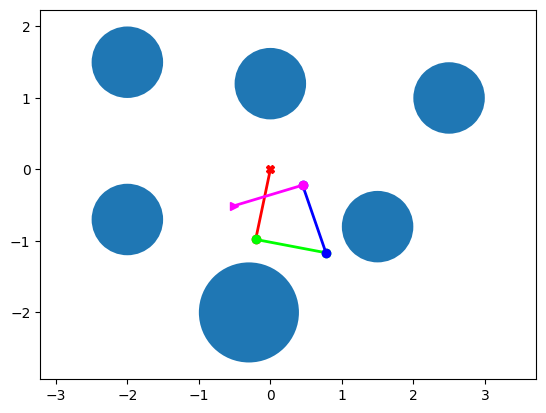

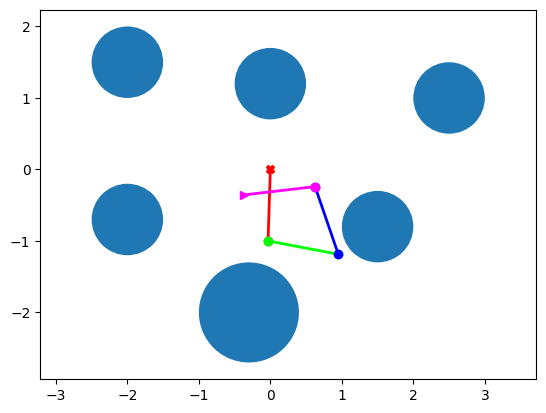

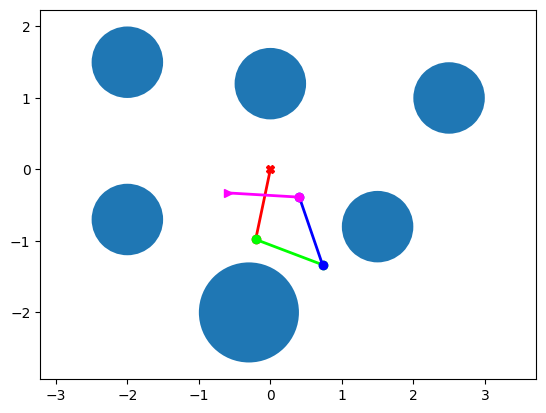

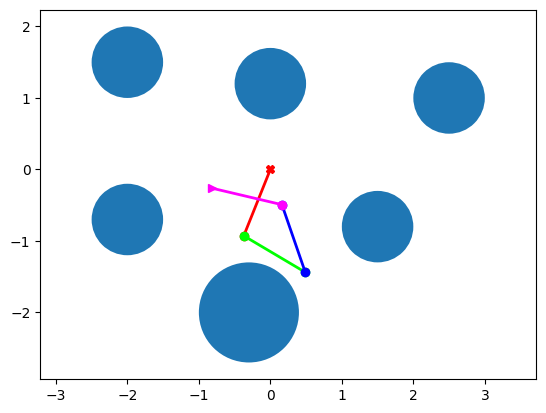

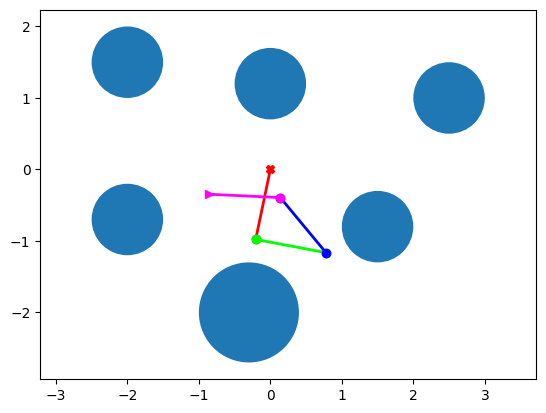

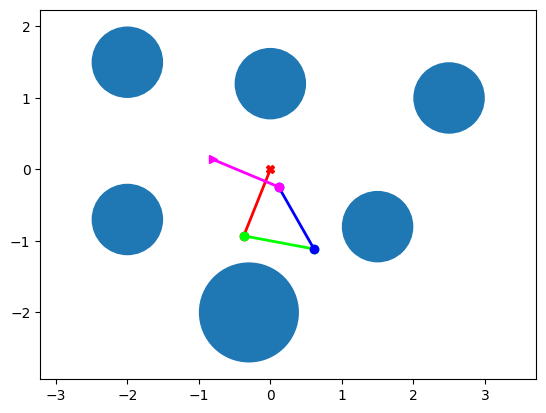

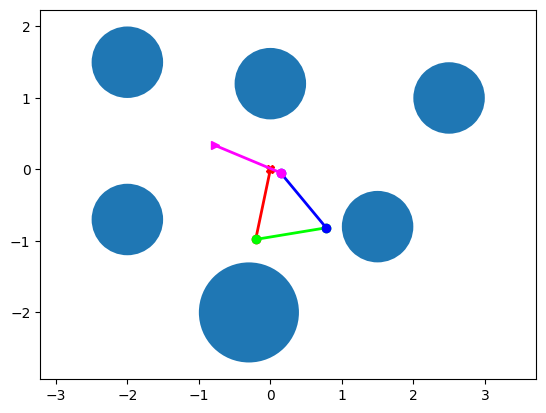

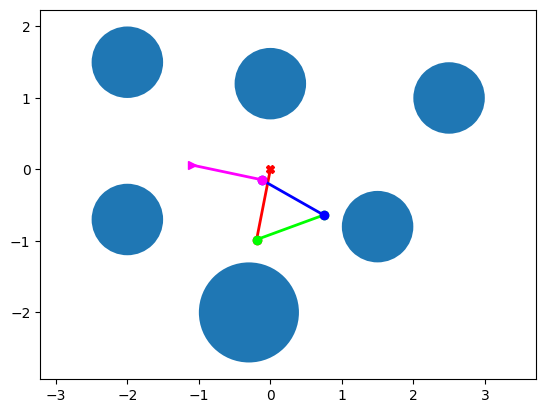

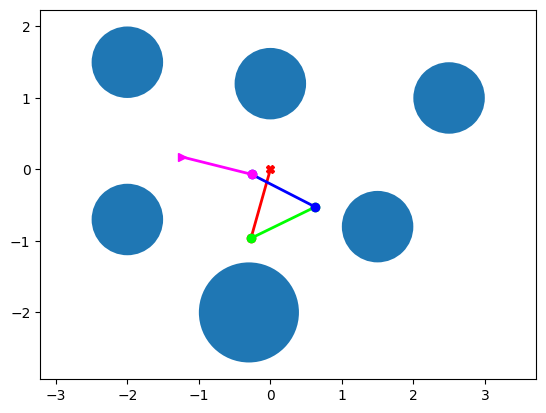

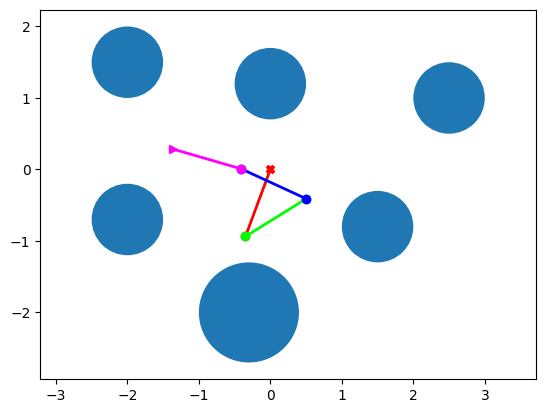

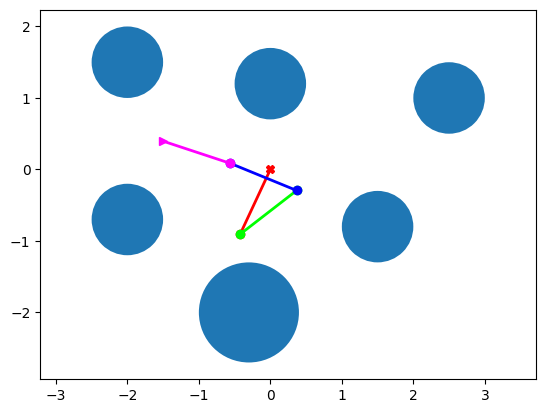

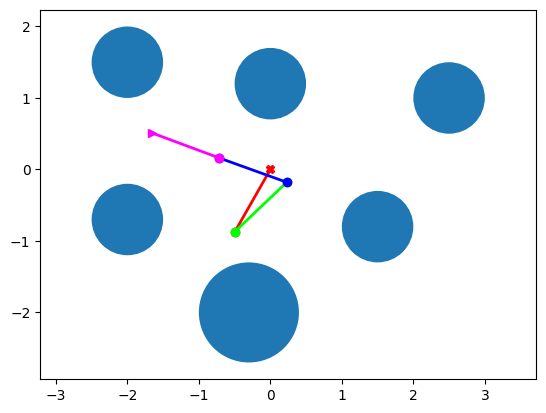

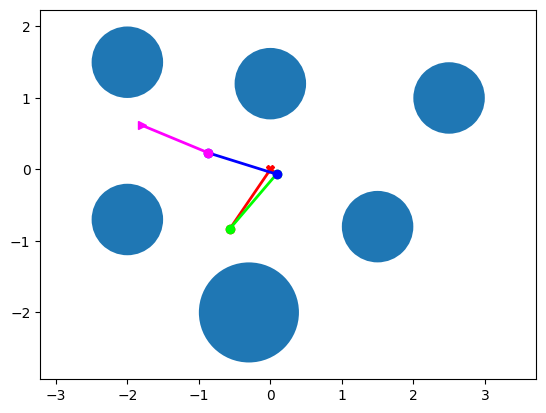

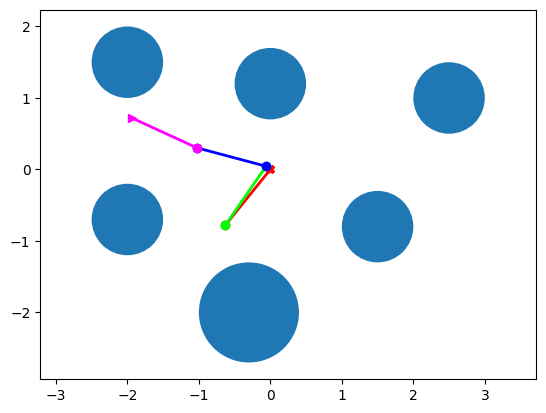

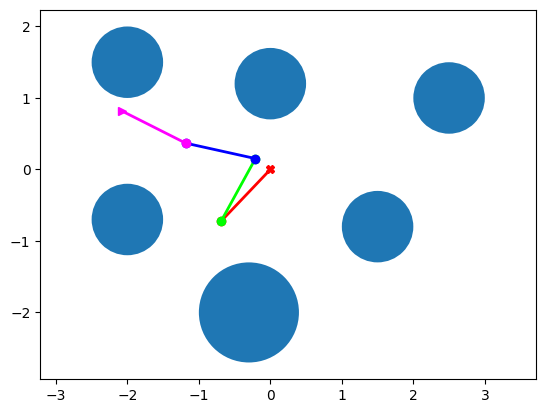

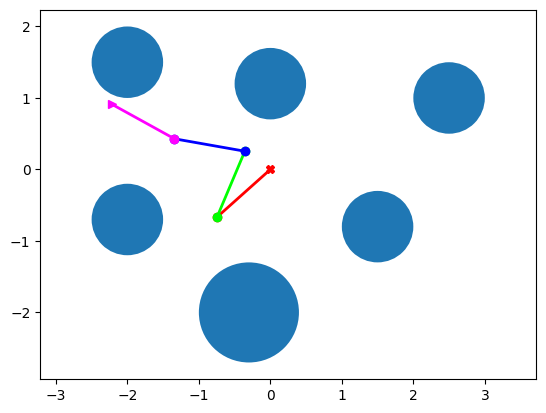

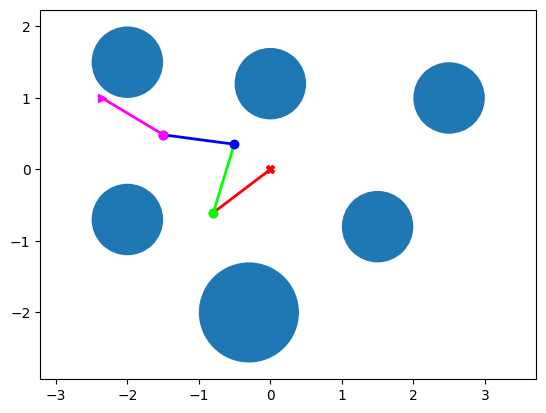

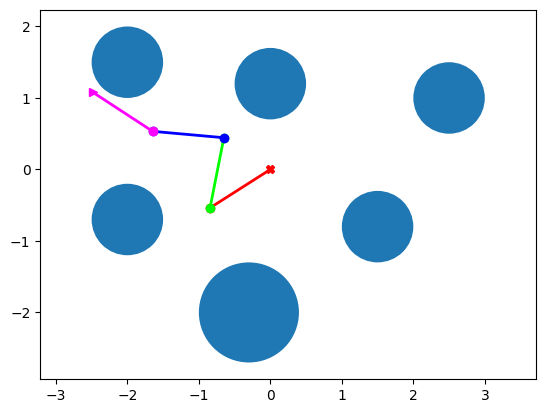

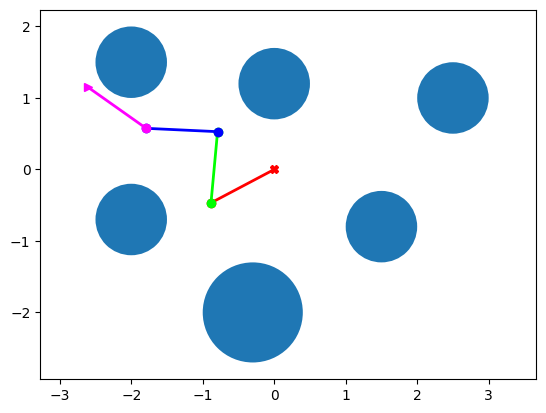

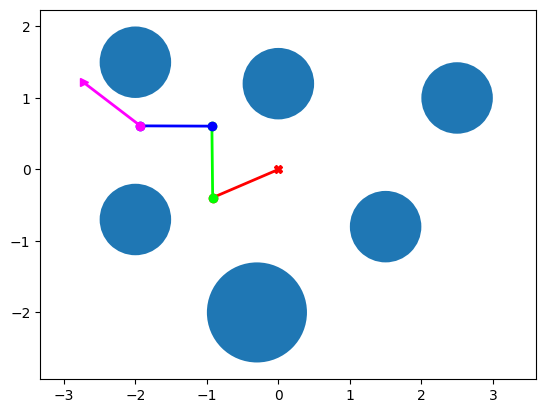

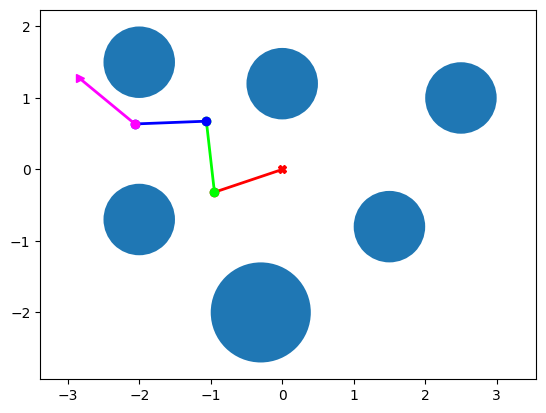

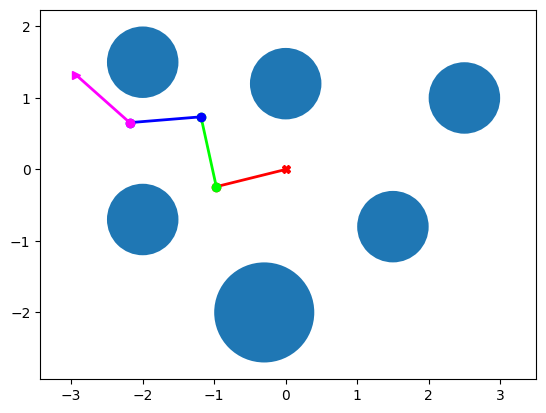

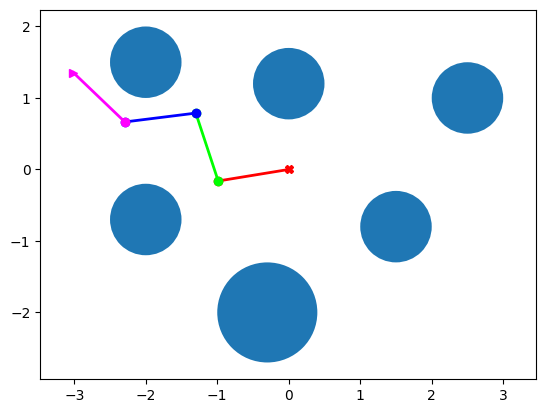

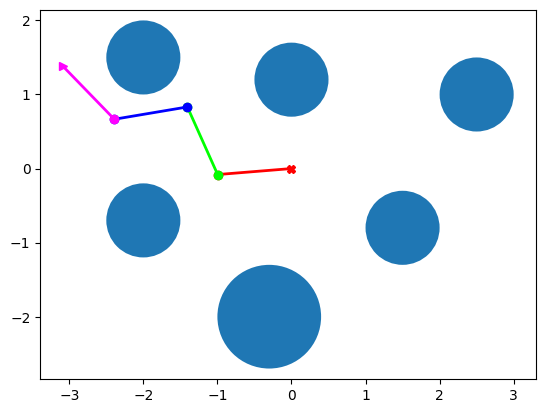

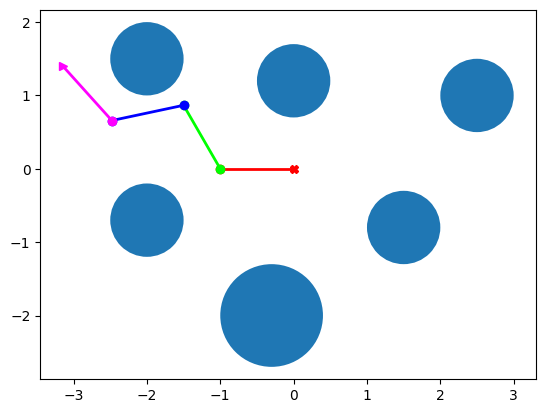

In [14]:
from typing import List, Callable

import numpy as np

from environment import State, ManipulatorEnv
import angle_util

import numpy as np
import pickle
from environment import State, ManipulatorEnv
from rrt import RRTPlanner
from video_util import animate_plan

class RRTPlanner:

    def __init__(self,
                 env: ManipulatorEnv,
                 distance_fn: Callable,
                 max_angle_step: float = 10.0):
        """
        :param env: manipulator environment
        :param distance_fn: function distance_fn(state1, state2) -> float
        :param max_angle_step: max allowed step for each joint in degrees
        """
        self._env = env
        self._distance_fn = distance_fn
        self._max_angle_step = max_angle_step

    
    def find_nearest(self,
                     q_rand,
                     G: List,
                     ):


        dist_min = 1000000
        near = []

        for i in G:
            if self._distance_fn(i[1], q_rand) < dist_min:
                dist_min = self._distance_fn(i[1], q_rand)
                near = i[1]       


        return near

    
    def steer(self,
              q_rand,
              q_near,
              ):
        
        s = 0.2
        T = False
        a = []
        for i in range(4):
            
            if angle_difference(q_rand[i], q_near[i]) > self._max_angle_step:
                a.append(self._max_angle_step)
            elif angle_difference(q_rand[i], q_near[i]) < -self._max_angle_step:
                a.append(-self._max_angle_step)
            else:
                a.append(angle_difference(q_rand[i], q_near[i]) * s)
            
            if q_near[i] + a[i] > 180:
                if len(a) == i+1:
                    a[i] = q_near[i] % 180 - 180
                else:
                    a.append(q_near[i] % 180 - 180)
            elif q_near[i] + a[i] < -180:
                if len(a) == i+1:
                    a[i] = q_near[i] % 180
                else:
                    a.append(q_near[i] % 180)
        return tuple(np.array(q_near) + a)

    
    
    def check_reach(
            self,
            q_new,
            start_state,
            goal_state,
            env: ManipulatorEnv,
            ):
        a = angle_difference(np.array(goal_state), np.array(q_new))
        if (a > -10).all() and (a < 10).all():
            if env.check_collision(State(q_new)) == False:
                return True, q_new
            
        else:
            b = int(max(abs(a // 10)))
            c = []
            result = angle_linspace(np.array(q_new), np.array(goal_state), b)
            
            
            for i in result:
                if env.check_collision(State(i)) == False:
                    c.append(i)
            if len(c) == len(result):
                return True, c
            
        return False, q_new


    def returning(
        self,
        start_state,
        goal_state,
        G: List,
        counter: int,
    ):
        s = []
        parent = []
        child = []
        
        for i in G:
            parent.append(tuple(i[1]))
            child.append(tuple(i[0]))

        
        a = child[-1] # child
        b = parent[-1] # parent
        c = [State(np.array(b))]
        
        T = True
        while (np.array(a) != start_state).any():
            b = a
            a = child[parent.index(a)]
            c.append(State(np.array(b)))
        c.append(State(np.array(b)))
        c.append(State(np.array(start_state)))
        c.reverse()
        print(f"There have been visited {counter} states")
        return c
    
    
    def plan(self,
             start_state: State,
             goal_state: State,
             samples: List,
             N: int,
             env: ManipulatorEnv,
             ):
        
        G = [(start_state.angles, start_state.angles)]
        counter = 1

        for i in range(N):
            q_rand = samples[i]

            q_near = self.find_nearest(q_rand, G)

            q_new = self.steer(q_rand, q_near)
            
            if env.check_collision(State(np.array(q_new))) == False:
                counter += 1
                G.append((q_near, q_new))
                
            T = False
            T, curr_item = self.check_reach(q_new, start_state.angles, goal_state.angles, env)
            if T == True:
                if type(curr_item) != list:
                    G.append((q_new, goal_state))
                    counter += 1
                else:
                    for i in range(1, len(curr_item)):
                        G.append((curr_item[i-1], curr_item[i]))
                        counter += 1
                return self.returning(start_state.angles, goal_state.angles, G, counter)
        
        return 0



def sampling(N):
    return np.random.uniform(low=-180.0, high=180.0, size=(N, 4))


def distance_func(vec_1, vec_2):
    return np.linalg.norm(vec_1 - vec_2, ord=1)



def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
    print(data)
    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=start_state,
                         collision_threshold=data["collision_threshold"])
    N = 4000
    samples = sampling(N)
    
    planner = RRTPlanner(env, distance_func)
    
    plan = planner.plan(start_state, goal_state, samples, N, env)
    print("The plan length:", len(plan)-1)
    animate_plan(env, plan)

if __name__ == '__main__':
    main()

Now the step size is increased from 0.01 to 0.2. The amount of the visited states became less, but the plan length remained the same.